In [16]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.special import erfc

def get_X0(lb, ub, N_0, DTYPE='float32'):
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.cast(np.random.uniform(lb[1], ub[1], (N_0, 1)), dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    return X_0

def get_XB(lb, ub, N_b, DTYPE='float32'):    
    t_b = tf.cast(np.random.uniform(lb[0], ub[0], (N_b,1)), dtype=DTYPE)
    x_b_0 = tf.ones((N_b,1),dtype=DTYPE)*lb[1]
    x_b_L = tf.ones((N_b,1),dtype=DTYPE)*ub[1]
    X_b_0 = tf.concat([t_b, x_b_0], axis=1)
    X_b_L = tf.concat([t_b, x_b_L], axis=1)
    return X_b_0, X_b_L

def get_Xr(lb, ub, N_r, DTYPE='float32'):    
    t_r = tf.cast(np.random.uniform(lb[0], ub[0], (N_r,1)), dtype=DTYPE)
    x_r = tf.cast(np.random.uniform(lb[1], ub[1], (N_r,1)), dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    return X_r


class TransientThermalModel:
    def __init__(self, k, d_b, Td, T_inf, L, Q_bias, sigma, epsilon_2, P_Torr, alpha, rho, c, a_cooler, b_cooler, time_steps, activation='tanh', initializer='glorot_normal'):
        self.k = k
        self.d_b = d_b
        self.Td = Td
        self.T_inf = T_inf
        self.L = L
        self.Q_bias = Q_bias
        self.sigma = sigma
        self.epsilon_2 = epsilon_2
        self.P_Torr = P_Torr
        self.alpha = alpha
        self.rho = rho
        self.c = c
        self.h = self.calculate_h_gc()
        self.a_cooler = a_cooler
        self.b_cooler = b_cooler
        self.time_steps = time_steps
        self.h_gc = self.calculate_h_gc()
        
        self.lb = tf.constant([0.0, 0.0], dtype=tf.float32)
        self.ub = tf.constant([self.time_steps, self.L], dtype=tf.float32)
        
        self.DTYPE = 'float32'
        
        self.Ac = np.pi * (tf.square(self.d_b / 2) - tf.square(self.d_b / 2 - 0.001))
        self.m2 = np.pi * self.d_b * self.h_gc / (self.k * self.Ac)
        self.m = tf.sqrt(self.m2)
        self.delta_V = self.Ac * self.L * 0.02 / 1001  # 볼륨 요소 크기 (적절히 조정)

        self.x_values = np.concatenate((np.linspace(0, 0.98 * self.L, num=500, endpoint=False),
                                        np.linspace(0.98 * self.L, self.L, num=1000+1))).reshape(-1, 1).astype(np.float32)
        #self.x_values = np.linspace(0, self.L, 1501).reshape(-1, 1).astype(np.float32)
        self.t_values = np.linspace(0, time_steps, num=20*time_steps+1).reshape(-1, 1).astype(np.float32)
        self.xt_values = np.array([[x, t] for t in self.t_values for x in self.x_values], dtype=np.float32)
        self.xt_tensor = tf.convert_to_tensor(self.xt_values, dtype=tf.float32)
        self.t_tensor = tf.convert_to_tensor(self.t_values, dtype=tf.float32)
        #self.log_vars = [tf.Variable(0.0, dtype=tf.float32) for _ in range(4)]
        #self.log_vars = [tf.Variable(tf.math.pow(10.0, tf.random.uniform([], minval=0, maxval=8, dtype=tf.float32)), dtype=tf.float32) for _ in range(4)]

        self.X_0, self.X_b_0, self.X_b_L, self.X_r = self.data_sampling()  

        self.activation = activation
        self.initializer = initializer
        self.model = self.build_model()
        self.trainable_parameters = self.model.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, amsgrad=True)

    def build_model(self):
        X_in = tf.keras.Input(shape=(2,))
        hiddens = tf.keras.layers.Lambda(lambda x: 2.0*(x - self.lb) / (self.ub-self.lb) - 1.0)(X_in)  # 입력 데이터 전처리
        for _ in range(4):
            hiddens = tf.keras.layers.Dense(20, kernel_initializer=self.initializer)(hiddens)
            hiddens = tf.keras.layers.Activation(self.activation)(hiddens)
        prediction = tf.keras.layers.Dense(1)(hiddens)
        prediction = 0.5*(prediction +1.)
        prediction = (self.T_inf-self.Td) * prediction
        prediction += self.Td
        model = tf.keras.Model(X_in, prediction)
        return model

    def data_sampling(self):    
        X_0 = get_X0(self.lb, self.ub, 250)
        X_b_0, X_b_L = get_XB(self.lb, self.ub, 250)
        X_r = get_Xr(self.lb, self.ub, 10000)
        return X_0, X_b_0, X_b_L, X_r

    def calculate_h_gc(self):
        P_fm = 4e-4  # Pressure of free molecule flow in Torr
        P_Torr_conversion_factor = 133.322  # Conversion factor from Torr to Pa
        
        if self.P_Torr < P_fm:
            return 1.48 * self.P_Torr * P_Torr_conversion_factor + 3 * self.epsilon_2
        elif P_fm <= self.P_Torr < 1:
            return (1.48 * self.P_Torr * P_Torr_conversion_factor) / (1 + 0.34 * self.P_Torr * P_Torr_conversion_factor) + \
                   3 * self.epsilon_2
        else:
            return 4.35 + 3 * self.epsilon_2

    def analytical_solution_at_L(self, t):
        """
        x = L에서 시간 t에 따른 해석적 해를 계산
        """
        T_inf = self.T_inf
        b = self.b_cooler
        a = self.a_cooler
        h_tilde = a / (self.k * self.Ac)
        return (T_inf + b / a) * tf.exp(h_tilde**2 * self.alpha * t) * erfc(h_tilde * tf.sqrt(self.alpha * t)) - b / a
            
    def compute_derivatives(self):
        with tf.GradientTape(persistent=True) as tape:
            t, x = tf.split(self.X_r, 2, axis=1)
            tape.watch(t)
            tape.watch(x)
            T = self.model(tf.stack([t[:,0], x[:,0]], axis=1))
            T_x = tape.gradient(T,x)
        T_t = tape.gradient(T,t)
        T_xx = tape.gradient(T_x,x)
        del tape
        return T, T_t, T_xx, T_x
    def fun_u_I(self):
        return self.T_inf
    def get_u_I(self):
        return self.model(self.X_0) 
    def get_b_L(self):
        with tf.GradientTape(persistent=True) as tape:
            t, x = tf.split(self.X_b_L, 2, axis=1)
            tape.watch(t)
            tape.watch(x)
            T = self.model(tf.stack([t[:,0], x[:,0]], axis=1))
        T_x = tape.gradient(T,x)
        del tape
        return T, T_x   

    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler = self.compute_loss()
        gradients = tape.gradient(total_loss, self.trainable_parameters)
        return gradients, total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler

    def compute_loss(self):
        T, dT_dt, d2T_dx2, dT_dx = self.compute_derivatives()
        pde_loss = tf.reduce_mean(tf.square(dT_dt - self.alpha * d2T_dx2))
        initial_condition = tf.reduce_mean(tf.square(self.model(self.X_0) - self.T_inf))
        boundary_condition_x0 = tf.reduce_mean(tf.square(self.model(self.X_b_0) - self.T_inf))
        
        T_b, dT_dt_b = self.get_b_L()
        boundary_condition_cooler = self.k* self.Ac*dT_dt_b + (self.a_cooler * T_b + self.b_cooler)
        boundary_condition_cooler = tf.reduce_mean(tf.square(boundary_condition_cooler))
        
        #pde_loss = tf.reduce_mean(tf.square(dT_dt - self.alpha * d2T_dx2 + (self.m2 / (self.rho * self.c)) * (T - self.T_inf)))
        total_loss = 1e5*pde_loss + 1e3*initial_condition + boundary_condition_x0 + 1e4*boundary_condition_cooler
        return total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler

    def train_step(self):
        gradients, total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler = self.get_grad()
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler

    def train(self, epochs):
        for epoch in range(epochs):
            total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler= self.train_step()
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
                print(f'PDE Loss: {pde_loss.numpy()}')
                print(f'Initial Condition Loss: {initial_condition.numpy()}')
                print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
                print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')
            #if pde_loss.numpy() <= 0.5 and initial_condition.numpy() <= 0.5 and boundary_condition_x0.numpy() <= 0.5 and boundary_condition_cooler.numpy() <= 0.5:
            #    print(f'Stopping early at epoch {epoch}')
            #    print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
            #    print(f'PDE Loss: {pde_loss.numpy()}')
            #    print(f'Initial Condition Loss: {initial_condition.numpy()}')
            #    print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
            #    print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')
            #    break
            if epoch == epochs-1:
                print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
                print(f'PDE Loss: {pde_loss.numpy()}')
                print(f'Initial Condition Loss: {initial_condition.numpy()}')
                print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
                print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')

    def predict_temperature(self):
        T_pred = self.model.predict(self.xt_tensor)
        return self.xt_values, T_pred

    def plot_temperature_distribution(self):
        xt_values, T_pred = self.predict_temperature()
        mpl.rcParams['font.family'] = 'Times New Roman'
        mpl.rcParams['mathtext.fontset'] = 'stix'  # 수학 표현에 대한 글꼴 설정
        mpl.rcParams['font.size'] = 20  # 기본 글꼴 크기 설정
        mpl.rcParams['figure.dpi'] = 400
        
        plt.figure(figsize=(5, 5))
        plt.scatter(xt_values[:, 0], xt_values[:, 1], c=T_pred.flatten(), cmap='jet', marker='.')
        plt.colorbar(label='Temperature (K)')
        plt.xlabel('Position along the cold well (m)')
        plt.ylabel('Time (s)')
        plt.title(f'Temperature Distribution along the Cold Well / {self.P_Torr:.0e} Torr.')
        plt.xlim(0, 0.048)
        plt.ylim(0, 30)
        plt.show()

    def plot_temperature_at_L(self):
        xL_t_values = tf.convert_to_tensor([[self.L, t] for t in self.t_values.flatten()], dtype=tf.float32)
        T_at_L = self.model(xL_t_values).numpy()

        plt.figure(figsize=(10, 10))
        plt.plot(self.t_values.flatten(), T_at_L.flatten(), label=f'Temperature at L = {self.L}')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
        plt.title(f'Temperature Distribution at L = {self.L} over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            weight_list = []
            shape_list = []
            
            for v in self.trainable_parameters:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            weight_list = tf.convert_to_tensor(weight_list)
            
            return weight_list, shape_list

        def set_weight_tensor(weight_list):
            idx = 0
            for v in self.trainable_parameters:
                vs = v.shape
                
                if len(vs) == 2:
                    sw = vs[0] * vs[1]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1]))
                    idx += sw
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx + vs[0]]
                    idx += vs[0]
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                elif len(vs) == 3:
                    sw = vs[0] * vs[1] * vs[2]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1], vs[2]))
                    idx += sw
                elif len(vs) == 4:
                    sw = vs[0] * vs[1] * vs[2] * vs[3]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1], vs[2], vs[3]))
                    idx += sw
                v.assign(tf.cast(new_val, self.DTYPE))

        def get_loss_and_grad(w):
            set_weight_tensor(w)
            with tf.GradientTape() as tape:
                total_loss, _, _, _, _ = self.compute_loss()
            grad = tape.gradient(total_loss, self.trainable_parameters)
            loss = total_loss.numpy().astype(np.float64)
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            grad_flat = np.array(grad_flat, dtype=np.float64)
            return loss, grad_flat

        x0, _ = get_weight_tensor()
        
        result = scipy.optimize.minimize(fun=get_loss_and_grad,
                                         x0=x0,
                                         jac=True,
                                         method=method,
                                         **kwargs)
        
        set_weight_tensor(result.x)
        return result

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define multiple test cases for transient model training and comparison
cases = {
    "Case A (ref)": {"k": 0.8, "epsilon": 0.02, "P_Torr": 1e0},
    "Case B (high-k)": {"k": 1.6, "epsilon": 0.02, "P_Torr": 1e0},
    "Case C (high-ε)": {"k": 0.8, "epsilon": 0.20, "P_Torr": 1e0},
    "Case D (low-P)": {"k": 0.8, "epsilon": 0.02, "P_Torr": 1e-4},
}

from collections import OrderedDict
results_T_L = OrderedDict()

# Run training and prediction for each case
for label, params in cases.items():
    print(f"Training {label}")
    model = TransientThermalModel(
        k=params["k"], d_b=0.009, Td=77, T_inf=300, L=0.048, Q_bias=0,
        sigma=5.67e-8, epsilon_2=params["epsilon"], P_Torr=params["P_Torr"],
        alpha=3.78787879e-7, rho=2640, c=800, a_cooler=0.039, b_cooler=-2, time_steps=30
    )
    
    model.train(epochs=500)  # You can increase epochs as needed
    model.ScipyOptimizer(method='L-BFGS-B',
                        options={'maxiter': 4000,
                                'maxfun': 50000,
                                'maxcor': 50,
                                'maxls': 50,
                                'ftol': np.finfo(float).eps,
                                'gtol': np.finfo(float).eps,
                                'factr': np.finfo(float).eps,
                                'iprint': 50})
    
    t_vals = model.t_values.flatten()
    xL_t_vals = tf.convert_to_tensor([[t, model.L] for t in t_vals], dtype=tf.float32)
    T_pred = model.model(xL_t_vals).numpy().flatten()
    results_T_L[label] = T_pred

Training Case A (ref)


Epoch: 0, Total Loss: 11229013.0
PDE Loss: 0.4266355335712433
Initial Condition Loss: 10983.0732421875
Boundary Condition at x=0 Loss: 7810.68603515625
Boundary Condition at x=L Loss: 19.546489715576172
Epoch: 100, Total Loss: 638832.6875
PDE Loss: 0.6943598985671997
Initial Condition Loss: 70.81655883789062
Boundary Condition at x=0 Loss: 29.12160301208496
Boundary Condition at x=L Loss: 49.855098724365234
Epoch: 200, Total Loss: 196802.65625
PDE Loss: 0.5517450571060181
Initial Condition Loss: 29.842195510864258
Boundary Condition at x=0 Loss: 17.56783676147461
Boundary Condition at x=L Loss: 11.176837921142578
Epoch: 300, Total Loss: 62059.0546875
PDE Loss: 0.10661070793867111
Initial Condition Loss: 14.860753059387207
Boundary Condition at x=0 Loss: 1.1539335250854492
Boundary Condition at x=L Loss: 3.6536078453063965
Epoch: 400, Total Loss: 41350.41796875
PDE Loss: 0.05105176568031311
Initial Condition Loss: 11.760498046875
Boundary Condition at x=0 Loss: 2.1505067348480225
Bounda

/var/folders/vq/tqxj_cr17_vgpvmk2hzmj_tw0000gn/T/ipykernel_8311/756929124.py:277: OptimizeWarning: Unknown solver options: factr
  result = scipy.optimize.minimize(fun=get_loss_and_grad,
 This problem is unconstrained.



At iterate   50    f=  1.23398D+04    |proj g|=  3.61911D+04

At iterate  100    f=  4.81192D+03    |proj g|=  2.46886D+04

At iterate  150    f=  2.56111D+03    |proj g|=  9.97938D+03

At iterate  200    f=  1.33500D+03    |proj g|=  1.77422D+04

At iterate  250    f=  7.49009D+02    |proj g|=  2.32526D+04

At iterate  300    f=  5.21605D+02    |proj g|=  1.96660D+04

At iterate  350    f=  3.30617D+02    |proj g|=  1.12499D+04

At iterate  400    f=  1.64689D+02    |proj g|=  3.01048D+03

At iterate  450    f=  1.23574D+02    |proj g|=  2.09052D+03

At iterate  500    f=  9.56812D+01    |proj g|=  2.83265D+03

At iterate  550    f=  8.28776D+01    |proj g|=  5.03647D+02

At iterate  600    f=  6.08954D+01    |proj g|=  1.65163D+03

At iterate  650    f=  4.91508D+01    |proj g|=  9.03612D+02

At iterate  700    f=  4.01996D+01    |proj g|=  4.86578D+02

At iterate  750    f=  3.31811D+01    |proj g|=  5.85914D+02

At iterate  800    f=  2.84230D+01    |proj g|=  2.68386D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Epoch: 0, Total Loss: 21929322.0
PDE Loss: 5.130636215209961
Initial Condition Loss: 21081.193359375
Boundary Condition at x=0 Loss: 14035.2265625
Boundary Condition at x=L Loss: 32.102752685546875
Epoch: 100, Total Loss: 647234.5
PDE Loss: 0.6938643455505371
Initial Condition Loss: 61.25954055786133
Boundary Condition at x=0 Loss: 18.425811767578125
Boundary Condition at x=L Loss: 51.657005310058594
Epoch: 200, Total Loss: 401966.125
PDE Loss: 0.7129338383674622
Initial Condition Loss: 59.85808563232422
Boundary Condition at x=0 Loss: 45.37369918823242
Boundary Condition at x=L Loss: 27.076927185058594
Epoch: 300, Total Loss: 77350.03125
PDE Loss: 0.18054012954235077
Initial Condition Loss: 22.07925796508789
Boundary Condition at x=0 Loss: 9.246941566467285
Boundary Condition at x=L Loss: 3.7207512855529785
Epoch: 400, Total Loss: 44398.3828125
PDE Loss: 0.08682863414287567
Initial Condition Loss: 15.17451000213623
Boundary Condition at x=0 Loss: 3.248044490814209
Boundary Condition a

 This problem is unconstrained.



At iterate   50    f=  1.56405D+04    |proj g|=  4.26076D+04

At iterate  100    f=  5.32474D+03    |proj g|=  8.72277D+03

At iterate  150    f=  2.40090D+03    |proj g|=  4.96513D+03

At iterate  200    f=  9.57129D+02    |proj g|=  1.16404D+04

At iterate  250    f=  3.71822D+02    |proj g|=  2.05446D+03

At iterate  300    f=  1.73528D+02    |proj g|=  1.18333D+03

At iterate  350    f=  1.06200D+02    |proj g|=  4.19953D+03

At iterate  400    f=  7.23457D+01    |proj g|=  8.15976D+02

At iterate  450    f=  5.79990D+01    |proj g|=  8.30876D+02

At iterate  500    f=  4.67632D+01    |proj g|=  1.57068D+03

At iterate  550    f=  3.43369D+01    |proj g|=  7.15570D+02

At iterate  600    f=  2.42795D+01    |proj g|=  3.42284D+02

At iterate  650    f=  2.06134D+01    |proj g|=  1.24409D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Epoch: 0, Total Loss: 26222726.0
PDE Loss: 8.150504112243652
Initial Condition Loss: 24771.994140625
Boundary Condition at x=0 Loss: 30063.017578125
Boundary Condition at x=L Loss: 60.56178283691406
Epoch: 100, Total Loss: 626885.0
PDE Loss: 0.762017011642456
Initial Condition Loss: 65.67179107666016
Boundary Condition at x=0 Loss: 1.4285595417022705
Boundary Condition at x=L Loss: 48.50101089477539
Epoch: 200, Total Loss: 336876.625
PDE Loss: 0.595723032951355
Initial Condition Loss: 58.558902740478516
Boundary Condition at x=0 Loss: 28.954805374145508
Boundary Condition at x=L Loss: 21.871644973754883
Epoch: 300, Total Loss: 104203.40625
PDE Loss: 0.13584043085575104
Initial Condition Loss: 32.24289321899414
Boundary Condition at x=0 Loss: 7.807498931884766
Boundary Condition at x=L Loss: 5.8368659019470215
Epoch: 400, Total Loss: 54336.3203125
PDE Loss: 0.06278961896896362
Initial Condition Loss: 18.544858932495117
Boundary Condition at x=0 Loss: 2.2262091636657715
Boundary Conditio

 This problem is unconstrained.



At iterate   50    f=  1.12325D+04    |proj g|=  3.89248D+04

At iterate  100    f=  3.07250D+03    |proj g|=  9.82979D+03

At iterate  150    f=  1.07539D+03    |proj g|=  1.23844D+04

At iterate  200    f=  4.61990D+02    |proj g|=  3.19060D+03

At iterate  250    f=  2.50605D+02    |proj g|=  1.47806D+03

At iterate  300    f=  1.24800D+02    |proj g|=  6.30311D+02

At iterate  350    f=  8.28668D+01    |proj g|=  1.63161D+03

At iterate  400    f=  5.08212D+01    |proj g|=  1.27625D+03

At iterate  450    f=  3.48063D+01    |proj g|=  9.43892D+02

At iterate  500    f=  2.31848D+01    |proj g|=  8.21302D+02

At iterate  550    f=  1.87283D+01    |proj g|=  5.70880D+02

At iterate  600    f=  1.35756D+01    |proj g|=  3.74148D+02

At iterate  650    f=  1.13456D+01    |proj g|=  2.03791D+02

At iterate  700    f=  9.40541D+00    |proj g|=  3.04333D+02

At iterate  750    f=  7.50452D+00    |proj g|=  6.49221D+02

At iterate  800    f=  6.03122D+00    |proj g|=  1.10389D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Epoch: 0, Total Loss: 17502790.0
PDE Loss: 1.554266333580017
Initial Condition Loss: 17139.7890625
Boundary Condition at x=0 Loss: 8113.5390625
Boundary Condition at x=L Loss: 19.945980072021484
Epoch: 100, Total Loss: 661835.0
PDE Loss: 0.6230617165565491
Initial Condition Loss: 71.54741668701172
Boundary Condition at x=0 Loss: 27.3179874420166
Boundary Condition at x=L Loss: 52.79541015625
Epoch: 200, Total Loss: 402677.78125
PDE Loss: 0.680755078792572
Initial Condition Loss: 50.16261291503906
Boundary Condition at x=0 Loss: 31.974462509155273
Boundary Condition at x=L Loss: 28.44076919555664
Epoch: 300, Total Loss: 105739.875
PDE Loss: 0.24890883266925812
Initial Condition Loss: 25.38266944885254
Boundary Condition at x=0 Loss: 5.110874652862549
Boundary Condition at x=L Loss: 5.546121120452881
Epoch: 400, Total Loss: 54103.19921875
PDE Loss: 0.08896920084953308
Initial Condition Loss: 16.507719039916992
Boundary Condition at x=0 Loss: 1.452199935913086
Boundary Condition at x=L Lo

 This problem is unconstrained.



At iterate   50    f=  1.51139D+04    |proj g|=  2.26650D+04

At iterate  100    f=  3.64001D+03    |proj g|=  1.17831D+04

At iterate  150    f=  1.58595D+03    |proj g|=  3.52385D+03

At iterate  200    f=  7.94905D+02    |proj g|=  9.26184D+03

At iterate  250    f=  3.22727D+02    |proj g|=  6.03559D+03

At iterate  300    f=  2.05151D+02    |proj g|=  1.13456D+03

At iterate  350    f=  1.22356D+02    |proj g|=  1.23382D+03

At iterate  400    f=  6.28375D+01    |proj g|=  2.27476D+03

At iterate  450    f=  3.96092D+01    |proj g|=  4.06707D+02

At iterate  500    f=  3.10144D+01    |proj g|=  5.37986D+02

At iterate  550    f=  2.56679D+01    |proj g|=  3.76870D+02

At iterate  600    f=  2.18312D+01    |proj g|=  2.83315D+02

At iterate  650    f=  1.90970D+01    |proj g|=  6.29611D+02

At iterate  700    f=  1.50992D+01    |proj g|=  2.81103D+02

At iterate  750    f=  9.51882D+00    |proj g|=  3.07703D+02

At iterate  800    f=  7.86913D+00    |proj g|=  1.48476D+02

At iter

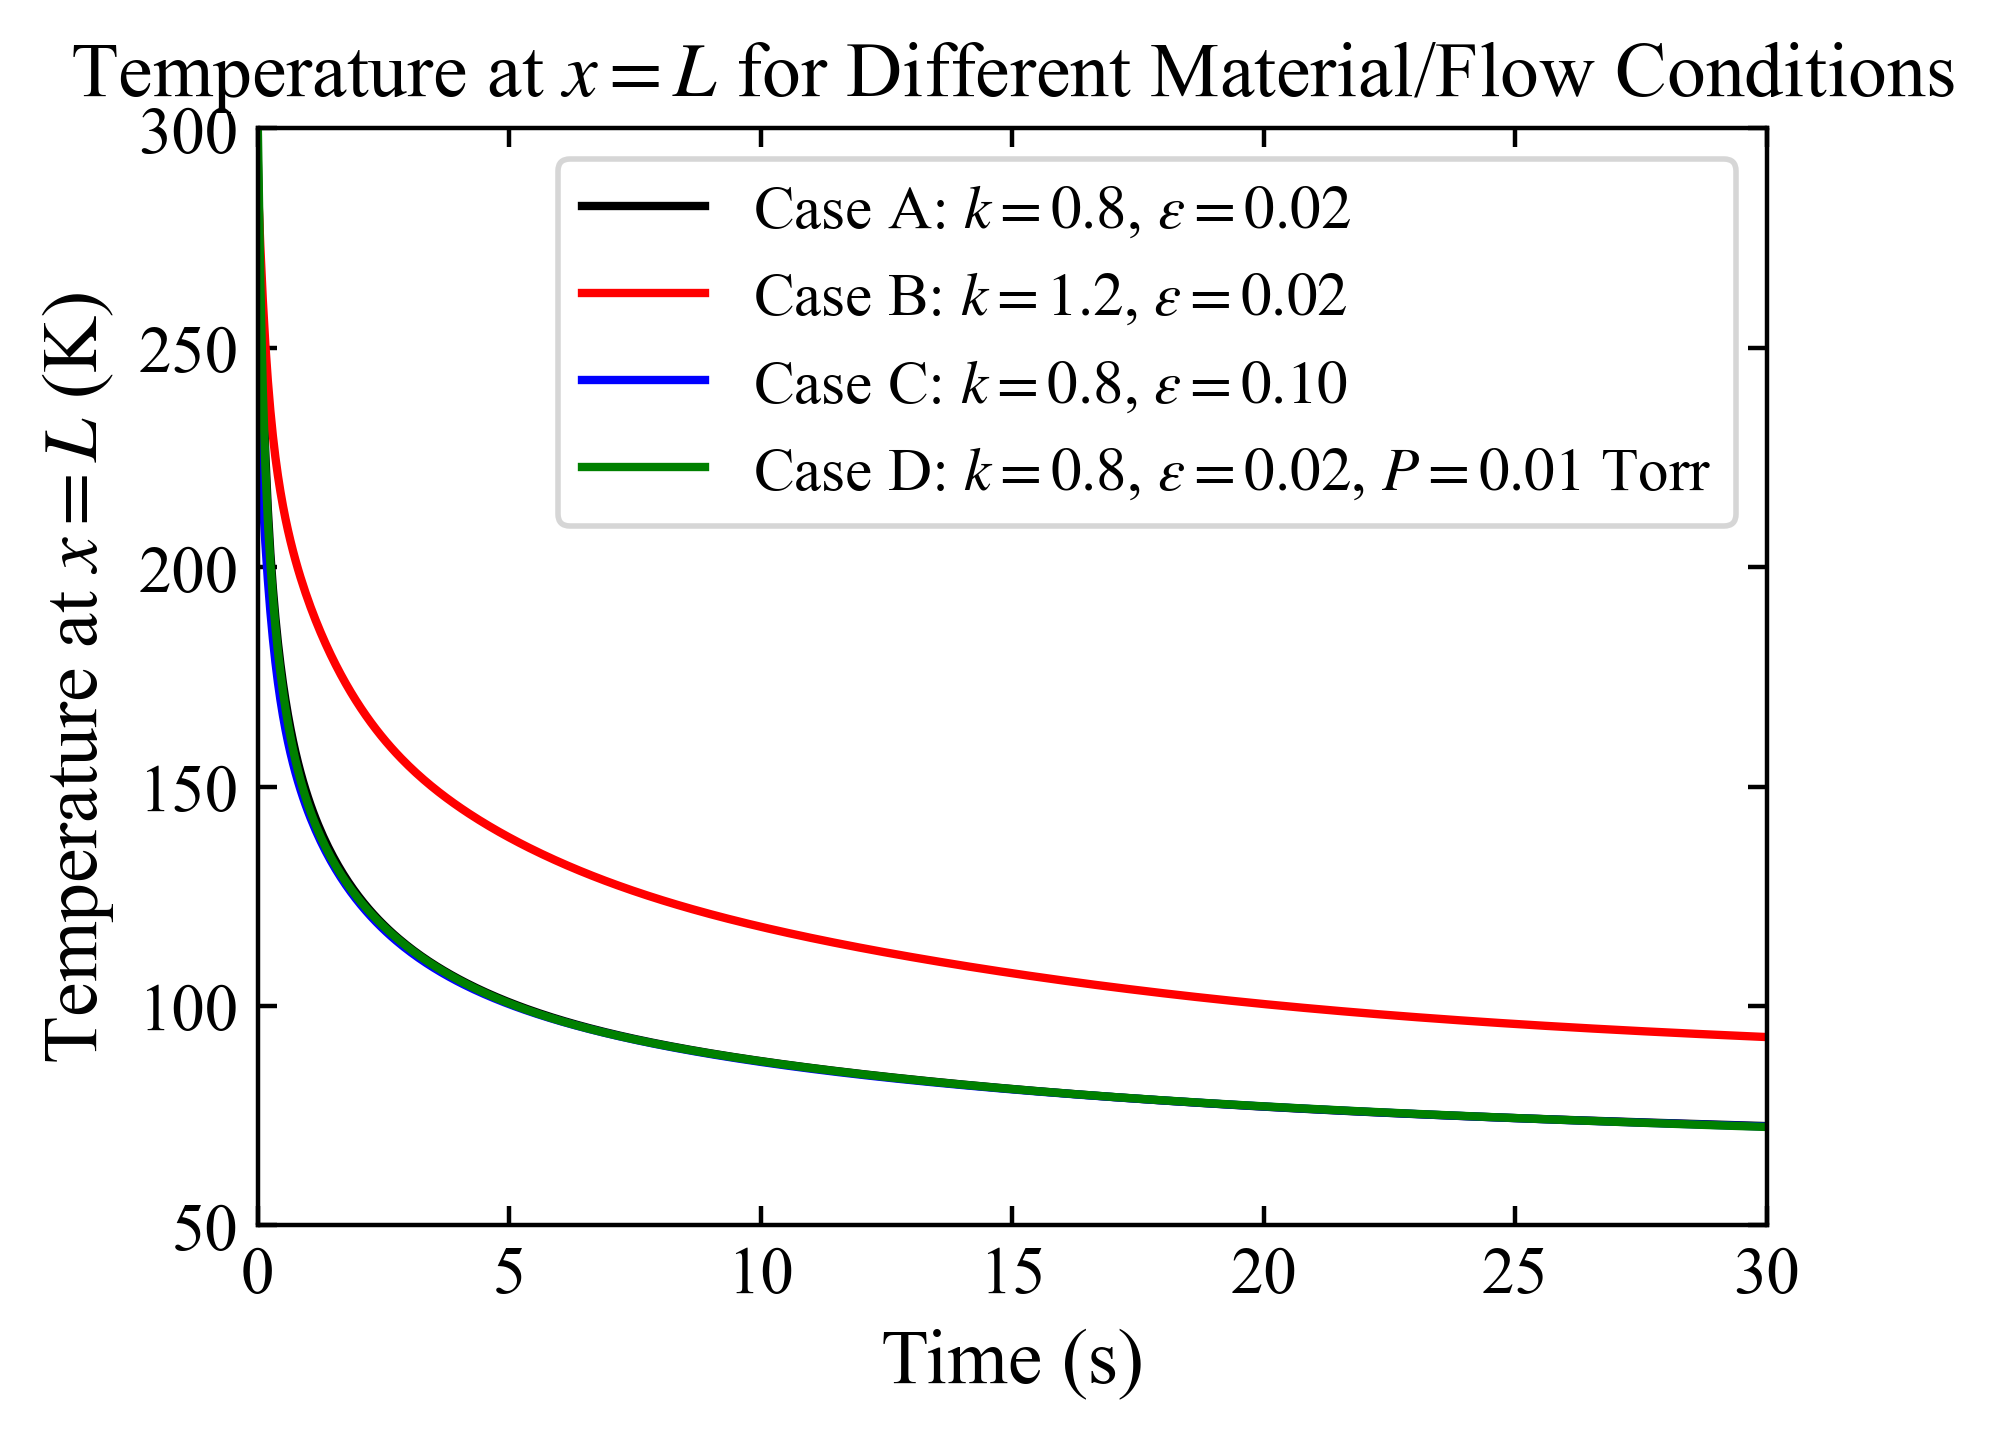

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl

class ThermalModel:
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['mathtext.fontset'] = 'stix'
    mpl.rcParams['font.size'] = 20
    mpl.rcParams['figure.dpi'] = 400

# Plotting all cases
t_values = model.t_values.flatten()
fig, ax = plt.subplots(figsize=(5, 4))

# Color and label formatting
colors = ["black", "red", "blue", "green"]
labels_for_plot = {
    "Case A (ref)": r"Case A: $k=0.8$, $\epsilon=0.02$",
    "Case B (high-k)": r"Case B: $k=1.2$, $\epsilon=0.02$",
    "Case C (high-ε)": r"Case C: $k=0.8$, $\epsilon=0.10$",
    "Case D (low-P)": r"Case D: $k=0.8$, $\epsilon=0.02$, $P=0.01$ Torr",
}

for label, color in zip(labels_for_plot.keys(), colors):
    ax.plot(t_values, results_T_L[label], color=color, label=labels_for_plot[label])

ax.set_xlim(0, 30)
ax.set_ylim(50, 300)
ax.set_xticks(np.arange(0, 31, 5))
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Temperature at $x=L$ (K)", fontsize=14)
ax.tick_params(axis='both', direction='in', labelsize=12, top=True, right=True)
ax.legend(fontsize=11, loc='best')
ax.set_title("Temperature at $x=L$ for Different Material/Flow Conditions", fontsize=14)
plt.tight_layout()
plt.show()

In [367]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.special import erfc

class ADAF(tf.keras.layers.Layer):
    def __init__(self, N_p=5, N_m=5, L=1.0, DTYPE='float32', kernel_regularizer=None):
        super(ADAF, self).__init__()
        self.N_p = N_p
        self.N_m = N_m
        self.L = L
        self.x_i = tf.cast(tf.linspace(0.0, L, N_p + 1), dtype=DTYPE)
        self.DTYPE = DTYPE
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.w = self.add_weight(name='w', shape=(), initializer='random_normal', regularizer=self.kernel_regularizer, trainable=True, dtype=self.DTYPE)
        self.W_i = self.add_weight(name='W_i', shape=(self.N_p,), initializer='random_normal', regularizer=self.kernel_regularizer, trainable=True, dtype=self.DTYPE)

    def out_an(self, n, x_1, x_2, W_i):
        if n == 0:
            a_n = tf.reduce_sum(W_i) / self.N_p
        else:
            sum_1 = tf.math.sin(n * np.pi / self.L * x_1)
            sum_2 = -tf.math.sin(n * np.pi / self.L * x_2)
            a_n = W_i * (sum_1 + sum_2)
            a_n = tf.reduce_sum(a_n)
            a_n = (2.0 / (n * np.pi)) * a_n
        return a_n

    def out_bn(self, n, x_1, x_2, W_i):
        sum_1 = -tf.math.cos(n * np.pi / self.L * x_1)
        sum_2 = tf.math.cos(n * np.pi / self.L * x_2)
        b_n = W_i * (sum_1 + sum_2)
        b_n = tf.reduce_sum(b_n)
        b_n = (2.0 / (n * np.pi)) * b_n
        return b_n

    def out_g_x_1(self, x):
        x_1 = self.x_i[1:]
        x_2 = self.x_i[:-1]

        g_x = self.out_an(0, x_1, x_2, self.W_i) / 2.0 * tf.math.square(x)
        for n in range(1, self.N_m + 1):
            factor = self.L / (n * np.pi)
            factor = tf.constant(factor, self.DTYPE)
            g_x += tf.math.square(factor) * self.out_an(n, x_1, x_2, self.W_i) * (1.0 - tf.math.cos(x / factor))
        return g_x

    def call(self, inputs):
        return self.w * self.out_g_x_1(inputs)

def get_X0(lb, ub, N_0, DTYPE='float32'):
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.cast(np.random.uniform(lb[1], ub[1], (N_0, 1)), dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    return X_0

def get_XB(lb, ub, N_b, DTYPE='float32'):    
    t_b = tf.cast(np.random.uniform(lb[0], ub[0], (N_b,1)), dtype=DTYPE)
    x_b_0 = tf.ones((N_b,1),dtype=DTYPE)*lb[1]
    x_b_L = tf.ones((N_b,1),dtype=DTYPE)*ub[1]
    X_b_0 = tf.concat([t_b, x_b_0], axis=1)
    X_b_L = tf.concat([t_b, x_b_L], axis=1)
    return X_b_0, X_b_L

def get_Xr(lb, ub, N_r, DTYPE='float32'):    
    t_r = tf.cast(np.random.uniform(lb[0], ub[0], (N_r,1)), dtype=DTYPE)
    x_r = tf.cast(np.random.uniform(lb[1], ub[1], (N_r,1)), dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    return X_r


class TransientThermalModel:
    def __init__(self, k, d_b, Td, T_inf, L, Q_bias, sigma, epsilon_2, P_Torr, alpha, rho, c, a_cooler, b_cooler, time_steps, activation='tanh', initializer='glorot_normal'):
        self.k = k
        self.d_b = d_b
        self.Td = Td
        self.T_inf = T_inf
        self.L = L
        self.Q_bias = Q_bias
        self.sigma = sigma
        self.epsilon_2 = epsilon_2
        self.P_Torr = P_Torr
        self.alpha = alpha
        self.rho = rho
        self.c = c
        self.h = self.calculate_h_gc()
        self.a_cooler = a_cooler
        self.b_cooler = b_cooler
        self.time_steps = time_steps
        self.h_gc = self.calculate_h_gc()
        
        self.lb = tf.constant([0.0, 0.0], dtype=tf.float32)
        self.ub = tf.constant([self.time_steps, self.L], dtype=tf.float32)
        
        self.DTYPE = 'float32'
        
        self.Ac = np.pi * (tf.square(self.d_b / 2) - tf.square(self.d_b / 2 - 0.001))
        self.m2 = np.pi * self.d_b * self.h_gc / (self.k * self.Ac)
        self.m = tf.sqrt(self.m2)
        self.delta_V = self.Ac * self.L * 0.02 / 1001  # 볼륨 요소 크기 (적절히 조정)
        self.delta_A = np.pi * tf.square(self.d_b / 2) + (np.pi * self.d_b * 0.001)
        self.x_values = np.concatenate((np.linspace(0, 0.98 * self.L, num=500, endpoint=False),
                                        np.linspace(0.98 * self.L, self.L, num=1000+1))).reshape(-1, 1).astype(np.float32)
        #self.x_values = np.linspace(0, self.L, 1501).reshape(-1, 1).astype(np.float32)
        self.t_values = np.linspace(0, time_steps, num=20*time_steps+1).reshape(-1, 1).astype(np.float32)
        self.xt_values = np.array([[x, t] for t in self.t_values for x in self.x_values], dtype=np.float32)
        self.xt_tensor = tf.convert_to_tensor(self.xt_values, dtype=tf.float32)
        self.t_tensor = tf.convert_to_tensor(self.t_values, dtype=tf.float32)
        #self.log_vars = [tf.Variable(0.0, dtype=tf.float32) for _ in range(4)]
        #self.log_vars = [tf.Variable(tf.math.pow(10.0, tf.random.uniform([], minval=0, maxval=8, dtype=tf.float32)), dtype=tf.float32) for _ in range(4)]

        self.X_0, self.X_b_0, self.X_b_L, self.X_r = self.data_sampling()  

        self.activation = activation
        self.initializer = initializer
        self.model = self.build_model()
        self.trainable_parameters = self.model.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, amsgrad=True)

    def build_model(self):
        X_in = tf.keras.Input(shape=(2,))
        hiddens = tf.keras.layers.Lambda(lambda x: 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0)(X_in)  # 입력 데이터 전처리
        for _ in range(4):
            hiddens = tf.keras.layers.Dense(20, kernel_initializer=self.initializer)(hiddens)
            hiddens = tf.keras.layers.Activation(self.activation)(hiddens)
        hiddens = tf.keras.layers.Dense(20, kernel_initializer=self.initializer)(hiddens)
        hiddens = ADAF(3, 3)(hiddens)
        hiddens = tf.keras.layers.Activation('tanh')(hiddens)
        prediction = tf.keras.layers.Dense(1)(hiddens)
        prediction = 0.5 * (prediction + 1.0)
        prediction = (self.T_inf - self.Td) * prediction
        prediction += self.Td
        model = tf.keras.Model(X_in, prediction)
        return model

    def data_sampling(self):    
        X_0 = get_X0(self.lb, self.ub, 500)
        X_b_0, X_b_L = get_XB(self.lb, self.ub, 5000)
        X_r = get_Xr(self.lb, self.ub, 5000)
        return X_0, X_b_0, X_b_L, X_r

    def calculate_h_gc(self):
        P_fm = 4e-4  # Pressure of free molecule flow in Torr
        P_Torr_conversion_factor = 133.322  # Conversion factor from Torr to Pa
        
        if self.P_Torr < P_fm:
            return 1.48 * self.P_Torr * P_Torr_conversion_factor
        elif P_fm <= self.P_Torr < 1:
            return (1.48 * self.P_Torr * P_Torr_conversion_factor) / (1 + 0.34 * self.P_Torr * P_Torr_conversion_factor)
        else:
            return 4.35

    def analytical_solution_at_L(self, t):
        """
        x = L에서 시간 t에 따른 해석적 해를 계산
        """
        T_inf = self.T_inf
        b = self.b_cooler
        a = self.a_cooler
        h_tilde = a / (self.k * self.Ac)
        return (T_inf + b / a) * tf.exp(h_tilde**2 * self.alpha * t) * erfc(h_tilde * tf.sqrt(self.alpha * t)) - b / a
            
    def compute_derivatives(self):
        with tf.GradientTape(persistent=True) as tape:
            t, x = tf.split(self.X_r, 2, axis=1)
            tape.watch(t)
            tape.watch(x)
            T = self.model(tf.stack([t[:,0], x[:,0]], axis=1))
            T_x = tape.gradient(T,x)
        T_t = tape.gradient(T,t)
        T_xx = tape.gradient(T_x,x)
        del tape
        return T, T_t, T_xx, T_x
    def fun_u_I(self):
        return self.T_inf
    def get_u_I(self):
        return self.model(self.X_0) 
    def get_b_L(self):
        with tf.GradientTape(persistent=True) as tape:
            t, x = tf.split(self.X_b_L, 2, axis=1)
            tape.watch(t)
            tape.watch(x)
            T = self.model(tf.stack([t[:,0], x[:,0]], axis=1))
        T_x = tape.gradient(T,x)
        del tape
        return T, T_x   

    def r_i(self, x_tensor):
        r_i0 = 0.025/2  # 고정 시작값
        alpha = 0.   # 테이퍼 고려 시 수정
        return r_i0 - alpha * x_tensor
    def r_o(self, x_tensor):
        r_o0 = self.d_b/2  # 고정 시작값
        alpha = 0.01    # 테이퍼 고려 시 수정
        return r_o0 - alpha * x_tensor
    def k_air_dynamic(self, x_tensor, T_tensor, p_Torr=None, k0=0.02638):
        if p_Torr is None:
            p_Torr = self.P_Torr * 0.00133322
        ri = self.r_i(x_tensor)
        D = (ri - (self.d_b / 2)) * 1e5  # micrometer 단위로 변환
        T_avg = 0.5 * (T_tensor + self.T_inf)
        denom = 1.0 + (7.6e-5 / (p_Torr * (D / T_avg)))
        return k0 / denom

    def get_dT_dt_b(self):
        with tf.GradientTape(persistent=True) as tape:
            t, x = tf.split(self.X_b_L, 2, axis=1)  # X_b_L 기준으로 사용
            tape.watch(t)
            T = self.model(tf.stack([t[:, 0], x[:, 0]], axis=1))
        dT_dt = tape.gradient(T, t)
        del tape
        return dT_dt
        
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler = self.compute_loss()
        gradients = tape.gradient(total_loss, self.trainable_parameters)
        return gradients, total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler

    def compute_loss(self):
        t_r, x_r = tf.split(self.X_r, 2, axis=1)
        T, dT_dt, d2T_dx2, dT_dx = self.compute_derivatives()
        # 동적 k_air 및 h_gc 계산
        k_air_x = self.k_air_dynamic(x_r, T)
        ro = self.r_i(x_r)
        ri = self.r_o(x_r)
        h_gc_x = k_air_x / (ri * tf.math.log1p(ro / ri))
        # Radiative term
        #Tm = 0.5 * (T + self.T_inf)
        #h_rad = 4.0 * self.sigma * self.epsilon_2 * tf.pow(Tm, 3)
        h_rad = self.sigma * self.epsilon_2 * (np.power(self.T_inf,2) + np.power(T,2))*(self.T_inf+T)
        h_total = h_gc_x + h_rad
        Ac = np.pi * ((ri)**2 - (ri - 0.001)**2)
        q_loss = np.pi * ri * 2 * h_total * (T - self.T_inf) / (self.rho * self.c * self.k * Ac)

        # PDE residual
        pde_loss = tf.reduce_mean(tf.square(dT_dt - self.alpha * d2T_dx2 + q_loss))

        # Boundary/Initial terms
        initial_condition = tf.reduce_mean(tf.square(self.model(self.X_0) - self.T_inf))
        boundary_condition_x0 = tf.reduce_mean(tf.square(self.model(self.X_b_0) - self.T_inf))
        dT_dt_b = self.get_dT_dt_b()

        T_b, dT_dx_b = self.get_b_L()
        delta_V = np.pi * ((0.0045-(0.01*0.048))**2) * 0.001  # 볼륨 요소 크기 (적절히 조정)
        delta_A = np.pi * tf.square((0.0045-(0.01*0.048))) + (np.pi * (0.0045-(0.01*0.048))*2 * 0.001)
        boundary_condition_cooler = (self.rho * self.c * delta_V * dT_dt_b) + \
            self.k * Ac * dT_dx_b + h_total * delta_A * (T_b - self.T_inf) + (self.a_cooler * T_b + self.b_cooler)
        boundary_condition_cooler = tf.reduce_mean(tf.square(boundary_condition_cooler))

        total_loss = 1e5*pde_loss + 1e3*initial_condition + boundary_condition_x0 + 1e4*boundary_condition_cooler
        return total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler


    def train_step(self):
        gradients, total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler = self.get_grad()
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler

    def train(self, epochs):
        for epoch in range(epochs):
            total_loss, pde_loss, initial_condition, boundary_condition_x0, boundary_condition_cooler= self.train_step()
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
                print(f'PDE Loss: {pde_loss.numpy()}')
                print(f'Initial Condition Loss: {initial_condition.numpy()}')
                print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
                print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')
            #if pde_loss.numpy() <= 0.5 and initial_condition.numpy() <= 0.5 and boundary_condition_x0.numpy() <= 0.5 and boundary_condition_cooler.numpy() <= 0.5:
            #    print(f'Stopping early at epoch {epoch}')
            #    print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
            #    print(f'PDE Loss: {pde_loss.numpy()}')
            #    print(f'Initial Condition Loss: {initial_condition.numpy()}')
            #    print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
            #    print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')
            #    break
            if epoch == epochs-1:
                print(f'Epoch: {epoch}, Total Loss: {total_loss.numpy()}')
                print(f'PDE Loss: {pde_loss.numpy()}')
                print(f'Initial Condition Loss: {initial_condition.numpy()}')
                print(f'Boundary Condition at x=0 Loss: {boundary_condition_x0.numpy()}')
                print(f'Boundary Condition at x=L Loss: {boundary_condition_cooler.numpy()}')

    def predict_temperature(self):
        T_pred = self.model.predict(self.xt_tensor)
        return self.xt_values, T_pred

    def plot_temperature_distribution(self):
        xt_values, T_pred = self.predict_temperature()
        mpl.rcParams['font.family'] = 'Times New Roman'
        mpl.rcParams['mathtext.fontset'] = 'stix'  # 수학 표현에 대한 글꼴 설정
        mpl.rcParams['font.size'] = 20  # 기본 글꼴 크기 설정
        mpl.rcParams['figure.dpi'] = 400
        
        plt.figure(figsize=(5, 5))
        plt.scatter(xt_values[:, 0], xt_values[:, 1], c=T_pred.flatten(), cmap='jet', marker='.')
        plt.colorbar(label='Temperature (K)')
        plt.xlabel('Position along the cold well (m)')
        plt.ylabel('Time (s)')
        plt.title(f'Temperature Distribution along the Cold Well / {self.P_Torr:.0e} Torr.')
        plt.xlim(0, 0.048)
        plt.ylim(0, 30)
        plt.show()

    def plot_temperature_at_L(self):
        xL_t_values = tf.convert_to_tensor([[self.L, t] for t in self.t_values.flatten()], dtype=tf.float32)
        T_at_L = self.model(xL_t_values).numpy()

        plt.figure(figsize=(10, 10))
        plt.plot(self.t_values.flatten(), T_at_L.flatten(), label=f'Temperature at L = {self.L}')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
        plt.title(f'Temperature Distribution at L = {self.L} over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            weight_list = []
            shape_list = []
            
            for v in self.trainable_parameters:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            weight_list = tf.convert_to_tensor(weight_list)
            
            return weight_list, shape_list

        def set_weight_tensor(weight_list):
            idx = 0
            for v in self.trainable_parameters:
                vs = v.shape
                
                if len(vs) == 2:
                    sw = vs[0] * vs[1]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1]))
                    idx += sw
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx + vs[0]]
                    idx += vs[0]
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                elif len(vs) == 3:
                    sw = vs[0] * vs[1] * vs[2]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1], vs[2]))
                    idx += sw
                elif len(vs) == 4:
                    sw = vs[0] * vs[1] * vs[2] * vs[3]
                    new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1], vs[2], vs[3]))
                    idx += sw
                v.assign(tf.cast(new_val, self.DTYPE))

        def get_loss_and_grad(w):
            set_weight_tensor(w)
            with tf.GradientTape() as tape:
                total_loss, _, _, _, _ = self.compute_loss()
            grad = tape.gradient(total_loss, self.trainable_parameters)
            loss = total_loss.numpy().astype(np.float64)
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            grad_flat = np.array(grad_flat, dtype=np.float64)
            return loss, grad_flat

        x0, _ = get_weight_tensor()
        
        result = scipy.optimize.minimize(fun=get_loss_and_grad,
                                         x0=x0,
                                         jac=True,
                                         method=method,
                                         **kwargs)
        
        set_weight_tensor(result.x)
        return result
    #여기부터
    def plot_hgc_hrad_snapshots(model, t_list=[0, 5, 10, 20, 30]):
        mpl.rcParams['font.size'] = 14
        x_vals = model.x_values.flatten()
        ri = model.d_b / 2.0
        ro = model.r_i(tf.convert_to_tensor(x_vals.reshape(-1, 1), dtype=tf.float32))

        plt.figure(figsize=(5, 4))
        for t_val in t_list:
            x_tensor = tf.convert_to_tensor(x_vals.reshape(-1, 1), dtype=tf.float32)
            t_tensor = tf.ones_like(x_tensor) * t_val
            xt_tensor = tf.concat([t_tensor, x_tensor], axis=1)
            T_pred = model.model(xt_tensor)
            k_air = model.k_air_dynamic(x_tensor, T_pred)
            h_gc = (k_air / (ri * tf.math.log1p(ro / ri))).numpy().flatten()

            plt.plot(x_vals, h_gc, label=f't = {t_val:.1f} s')
        
        plt.xlabel('Position x (m)')
        plt.ylabel('h_gc(x, t) [W/m²·K]')
        plt.title('Spatial Variation of h_gc at Different Times')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_delta_T_distribution(model):
        xt_values, T_pred = model.predict_temperature()
        delta_T = T_pred.flatten() - model.T_inf

        plt.figure(figsize=(6, 5))
        plt.scatter(xt_values[:, 0], xt_values[:, 1], c=delta_T, cmap='seismic', marker='.', vmin=-150, vmax=150)
        plt.colorbar(label='ΔT = T - T_inf (K)')
        plt.xlabel('x (m)')
        plt.ylabel('Time (s)')
        plt.title('ΔT Distribution Over Space and Time')
        plt.tight_layout()
        plt.show()

    def plot_htotal_at_final_time(model):
        x_vals = model.x_values.flatten()
        t_final = model.time_steps
        x_tensor = tf.convert_to_tensor(x_vals.reshape(-1, 1), dtype=tf.float32)
        t_tensor = tf.ones_like(x_tensor) * t_final
        xt_tensor = tf.concat([t_tensor, x_tensor], axis=1)

        T_pred = model.model(xt_tensor)
        k_air = model.k_air_dynamic(x_tensor, T_pred)
        ri = model.d_b / 2.0
        ro = model.r_i(x_tensor)
        h_gc = k_air / (ri * tf.math.log1p(ro / ri))
        h_rad = model.sigma * model.epsilon_2 * (tf.pow(model.T_inf, 2) + tf.pow(T_pred, 2)) * (model.T_inf + T_pred)
        h_total = (h_gc + h_rad).numpy().flatten()

        plt.figure()
        plt.plot(x_vals, h_total)
        plt.xlabel('x (m)')
        plt.ylabel('h_total(x, t_final) [W/m²·K]')
        plt.title('Total Heat Transfer Coefficient at Final Time')
        plt.grid(True)
        plt.show()
    

In [368]:
import matplotlib.pyplot as plt
import numpy as np

# Define multiple test cases for transient model training and comparison
cases = {
    "Case A (ref)": {"k": 0.8, "epsilon": 0.02, "P_Torr": 1e-3},
    #"Case B (high-k)": {"k": 4.0, "epsilon": 0.02, "P_Torr": 1e-0},
    #"Case C (high-ε)": {"k": 1.4, "epsilon": 0.80, "P_Torr": 1e-0},
    #"Case D (low-P)": {"k": 1.4, "epsilon": 0.02, "P_Torr": 1e-4},
}

from collections import OrderedDict
results_T_L = OrderedDict()

# Run training and prediction for each case
for label, params in cases.items():
    print(f"Training {label}")
    model = TransientThermalModel(
        k=params["k"], d_b=0.009, Td=77, T_inf=300, L=0.048, Q_bias=0,
        sigma=5.67e-8, epsilon_2=params["epsilon"], P_Torr=params["P_Torr"],
        alpha=3.78787879e-7, rho=2640, c=800, a_cooler=0.039, b_cooler=-2, time_steps=30
    )
    
    model.train(epochs=500)  # You can increase epochs as needed
    model.ScipyOptimizer(method='L-BFGS-B',
                     options={'maxiter': 4000,
                              'maxfun': 50000,
                              'maxcor': 50,
                              'maxls': 50,
                              'ftol': np.finfo(float).eps,
                              'gtol': np.finfo(float).eps,
                              'factr': np.finfo(float).eps,
                              'iprint': 50})
    
    t_vals = model.t_values.flatten()
    xL_t_vals = tf.convert_to_tensor([[t, model.L] for t in t_vals], dtype=tf.float32)
    T_pred = model.model(xL_t_vals).numpy().flatten()
    results_T_L[label] = T_pred

Training Case A (ref)


Epoch: 0, Total Loss: 12731798.0
PDE Loss: 0.0005559057462960482
Initial Condition Loss: 12433.23046875
Boundary Condition at x=0 Loss: 12433.2109375
Boundary Condition at x=L Loss: 28.607925415039062
Epoch: 100, Total Loss: 489418.09375
PDE Loss: 0.32619011402130127
Initial Condition Loss: 20.563722610473633
Boundary Condition at x=0 Loss: 3.292545795440674
Boundary Condition at x=L Loss: 43.623207092285156
Epoch: 200, Total Loss: 31493.6640625
PDE Loss: 0.06370733678340912
Initial Condition Loss: 8.667641639709473
Boundary Condition at x=0 Loss: 0.03656168282032013
Boundary Condition at x=L Loss: 1.645525336265564
Epoch: 300, Total Loss: 12046.626953125
PDE Loss: 0.023665128275752068
Initial Condition Loss: 4.379513740539551
Boundary Condition at x=0 Loss: 0.01766543835401535
Boundary Condition at x=L Loss: 0.5300583243370056
Epoch: 400, Total Loss: 5592.6904296875
PDE Loss: 0.009850036352872849
Initial Condition Loss: 2.477384567260742
Boundary Condition at x=0 Loss: 0.0164567939937

/var/folders/vq/tqxj_cr17_vgpvmk2hzmj_tw0000gn/T/ipykernel_8311/2870542078.py:373: OptimizeWarning: Unknown solver options: factr
  result = scipy.optimize.minimize(fun=get_loss_and_grad,


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1765     M =           50

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38670D+03    |proj g|=  4.76680D+03


 This problem is unconstrained.



At iterate   50    f=  1.50135D+03    |proj g|=  8.09389D+03

At iterate  100    f=  6.63744D+02    |proj g|=  5.01839D+03

At iterate  150    f=  3.84605D+02    |proj g|=  1.83692D+03

At iterate  200    f=  2.29739D+02    |proj g|=  2.89399D+03

At iterate  250    f=  1.63998D+02    |proj g|=  1.16554D+03

At iterate  300    f=  1.27910D+02    |proj g|=  2.04736D+03

At iterate  350    f=  1.13519D+02    |proj g|=  1.66692D+03

At iterate  400    f=  9.39996D+01    |proj g|=  4.43039D+02

At iterate  450    f=  8.36423D+01    |proj g|=  1.18643D+03

At iterate  500    f=  6.90057D+01    |proj g|=  1.68374D+03

At iterate  550    f=  6.04636D+01    |proj g|=  9.73976D+02

At iterate  600    f=  5.39053D+01    |proj g|=  3.60033D+02

At iterate  650    f=  4.92488D+01    |proj g|=  1.03986D+03

At iterate  700    f=  4.49162D+01    |proj g|=  4.45460D+02

At iterate  750    f=  4.12434D+01    |proj g|=  6.95900D+02

At iterate  800    f=  3.74771D+01    |proj g|=  1.25642D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [369]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (필수 import)
from matplotlib import cm
from matplotlib.ticker import FuncFormatter

def custom_formatter(x, pos):
    if np.isclose(x, 0.0):  # x가 0과 거의 같으면
        return "0"
    else:
        return f"{x:.1f}"
def plot_h_surfaces(x_vals, t_vals, h_gc, h_rad, h_total):
    # meshgrid 생성
    T_grid, X_grid = np.meshgrid(t_vals, x_vals*1000)

    # 3D 플롯
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 각 surface
    surf1 = ax.plot_surface(X_grid, T_grid, h_gc, cmap=cm.Reds, alpha=0.9, label='h_gc')
    surf2 = ax.plot_surface(X_grid, T_grid, h_rad, cmap=cm.Blues, alpha=0.9, label='h_rad')
    surf3 = ax.plot_surface(X_grid, T_grid, h_total, cmap=cm.Purples, alpha=0.9, label='h_total')

    # 라벨 및 보기 설정
    ax.set_xlabel('$x$ (mm)', labelpad=20)
    ax.set_xlim(0, 0.048)
    ax.set_xticks(np.arange(0, 49, 8))
    ax.set_ylabel('Time (s)', labelpad=20)
    ax.set_ylim(0, 30)
    ax.set_zlabel('Heat Transfer Coefficient (W/m²·K)', labelpad=20)
    ax.set_zlim(0, 0.35)
    ax.set_zticks(np.linspace(0, 0.40, 5))
    ax.zaxis.set_major_formatter(FuncFormatter(custom_formatter))
    ax.view_init(elev=30, azim=45)
    ax.grid(False)
    #plt.tight_layout()
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    
    plt.show()
# 시간 및 위치 벡터
x_vals = model.x_values.flatten()              # shape (Nx,)
t_vals = model.t_values.flatten()              # shape (Nt,)

# 빈 배열 생성
h_gc_array = np.zeros((len(x_vals), len(t_vals)))
h_rad_array = np.zeros((len(x_vals), len(t_vals)))
h_total_array = np.zeros((len(x_vals), len(t_vals)))


# 계산 루프
for j, t in enumerate(t_vals):
    x_tensor = tf.convert_to_tensor(x_vals.reshape(-1, 1), dtype=tf.float32)
    t_tensor = tf.ones_like(x_tensor) * t
    xt_tensor = tf.concat([t_tensor, x_tensor], axis=1)

    T_pred = model.model(xt_tensor)
    k_air = model.k_air_dynamic(x_tensor, T_pred)
    
    ri = model.d_b / 2.0
    ro = model.r_i(x_tensor)
    
    h_gc = (k_air / (ri * tf.math.log1p(ro / ri))).numpy().flatten()
    T_inf_f32 = tf.cast(model.T_inf, tf.float32)
    h_rad = model.sigma * model.epsilon_2 * (tf.pow(T_inf_f32, 2) + tf.pow(T_pred, 2)) * (T_inf_f32 + T_pred)
    h_rad = h_rad.numpy().flatten()
    h_total = h_gc + h_rad

    h_gc_array[:, j] = h_gc
    h_rad_array[:, j] = h_rad
    h_total_array[:, j] = h_total

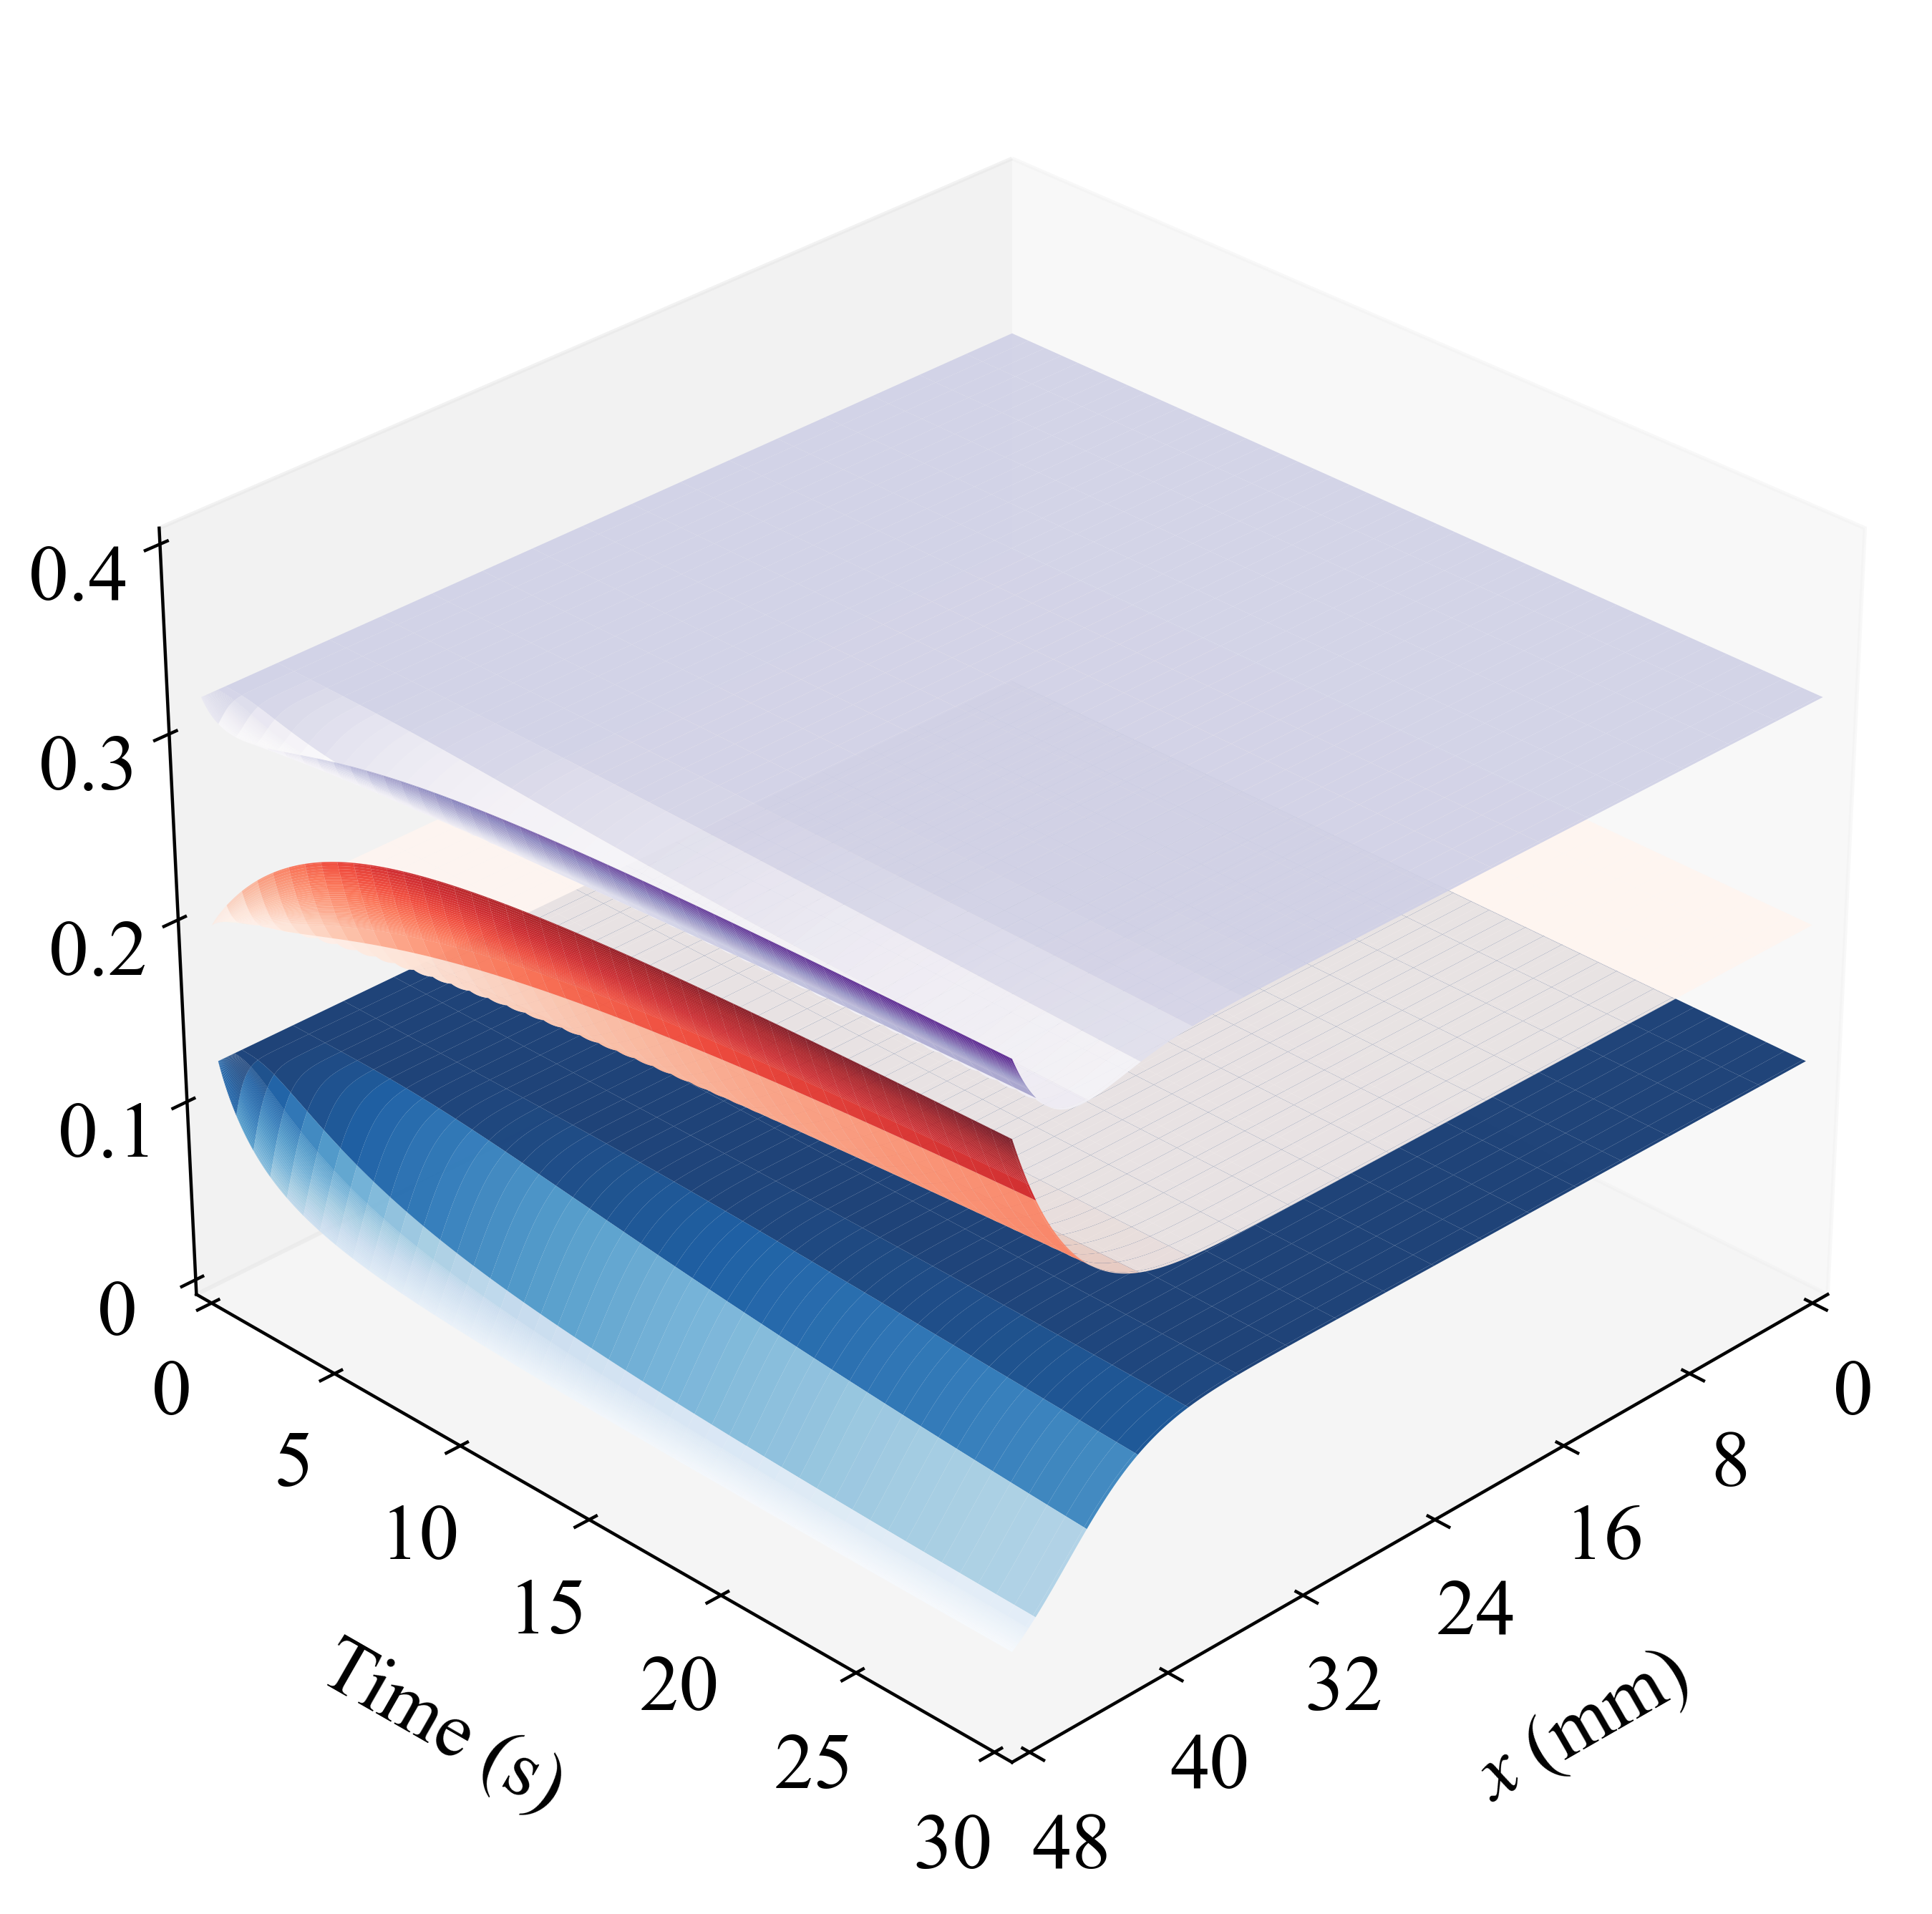

In [370]:
plot_h_surfaces(
    x_vals=x_vals,              # shape: (N,)
    t_vals=t_vals,              # shape: (M,)
    h_gc=h_gc_array,            # shape: (N, M)
    h_rad=h_rad_array,          # shape: (N, M)
    h_total=h_total_array       # shape: (N, M)
)


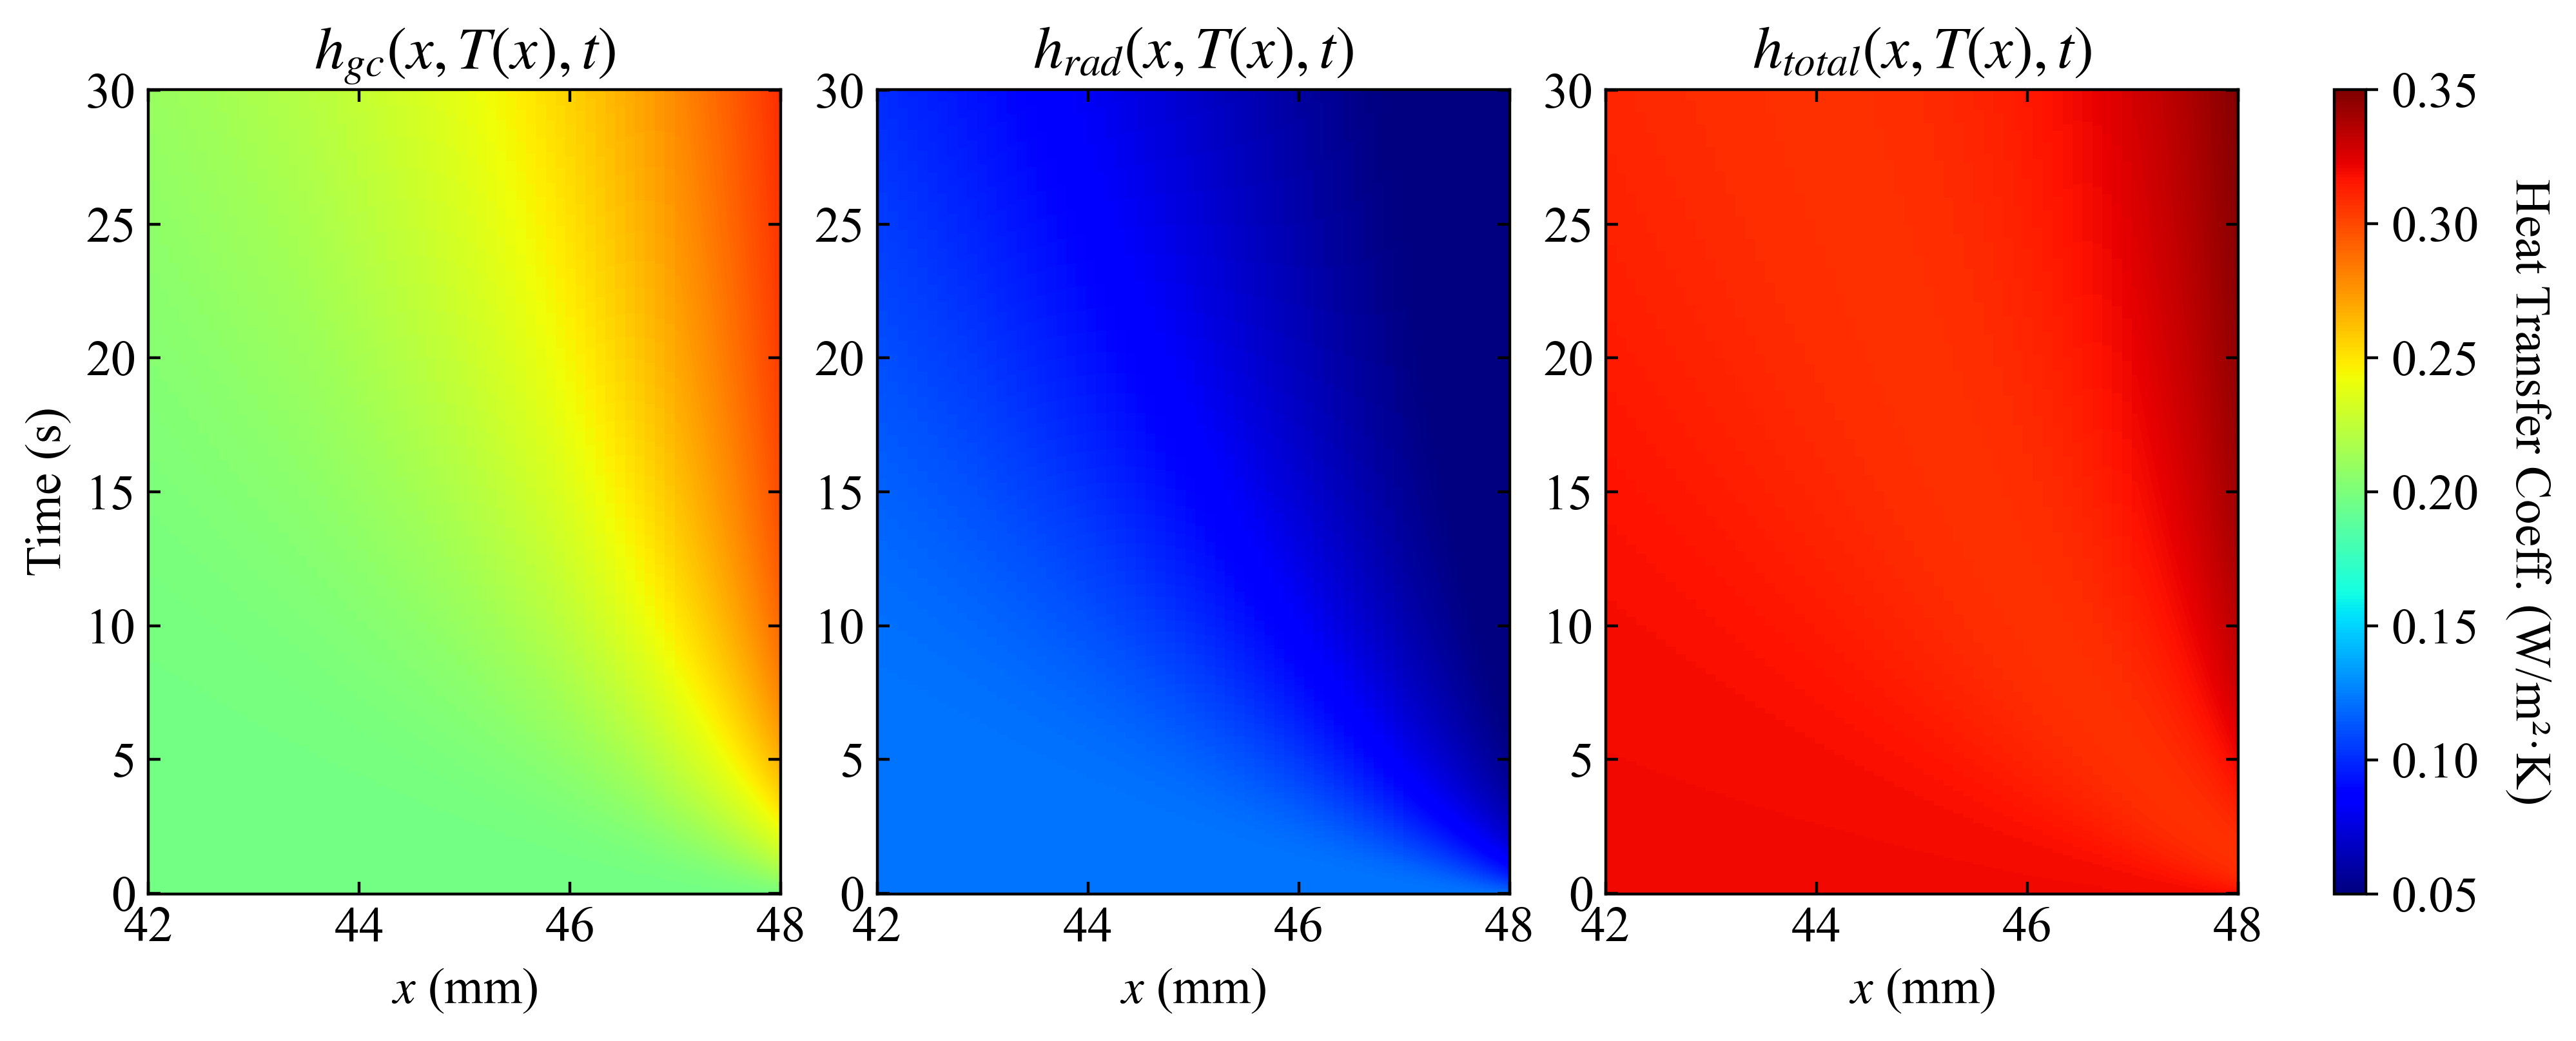

In [491]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import numpy as np
from matplotlib.colors import LogNorm

class ThermalModel:
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['mathtext.fontset'] = 'stix'
    mpl.rcParams['font.size'] = 14
    mpl.rcParams['figure.dpi'] = 400
def plot_heatmaps_1row3cols_external_cbar(x_vals, t_vals, h_gc_array, h_rad_array, h_total_array):
    x_mm = x_vals * 1000
    T_grid, X_grid = np.meshgrid(t_vals, x_mm)

    # 그리드 설정: 1행 4열 (3개 plot + 1개 colorbar)
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.2)

    # 축 설정
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharey=ax1)
    ax3 = fig.add_subplot(gs[2], sharey=ax1)
    cax = fig.add_subplot(gs[3])  # colorbar axis

    # 컬러맵 범위
    vmin = 0.05
    vmax = 0.35
    cmap = cm.jet

    # 각 heatmap
    im1 = ax1.pcolormesh(X_grid, T_grid, h_gc_array, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax1.set_title(r"$h_{gc}(x, T(x), t)$")
    ax1.set_xlabel("$x$ (mm)")
    ax1.set_xlim(42, 48)
    ax1.set_xticks(np.arange(42, 50, 2))
    ax1.set_ylabel("Time (s)")
    ax1.tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)

    im2 = ax2.pcolormesh(X_grid, T_grid, h_rad_array, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax2.set_title(r"$h_{rad}(x, T(x), t)$")
    ax2.set_xlabel("$x$ (mm)")
    ax2.set_xlim(42, 48)
    ax2.set_xticks(np.arange(42, 50, 2))
    ax2.tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)

    im3 = ax3.pcolormesh(X_grid, T_grid, h_total_array, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax3.set_title(r"$h_{total}(x, T(x), t)$")
    ax3.set_xlabel("$x$ (mm)")
    ax3.set_xlim(42, 48)
    ax3.set_xticks(np.arange(42, 50, 2))
    ax3.tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)

    # 공통 colorbar
    cbar = fig.colorbar(im3, cax=cax)
    cbar.set_label('Heat Transfer Coeff. (W/m²·K)', labelpad=20, rotation=270)

    plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.12)
    plt.show()

plot_heatmaps_1row3cols_external_cbar(x_vals, t_vals, h_gc_array, h_rad_array, h_total_array)


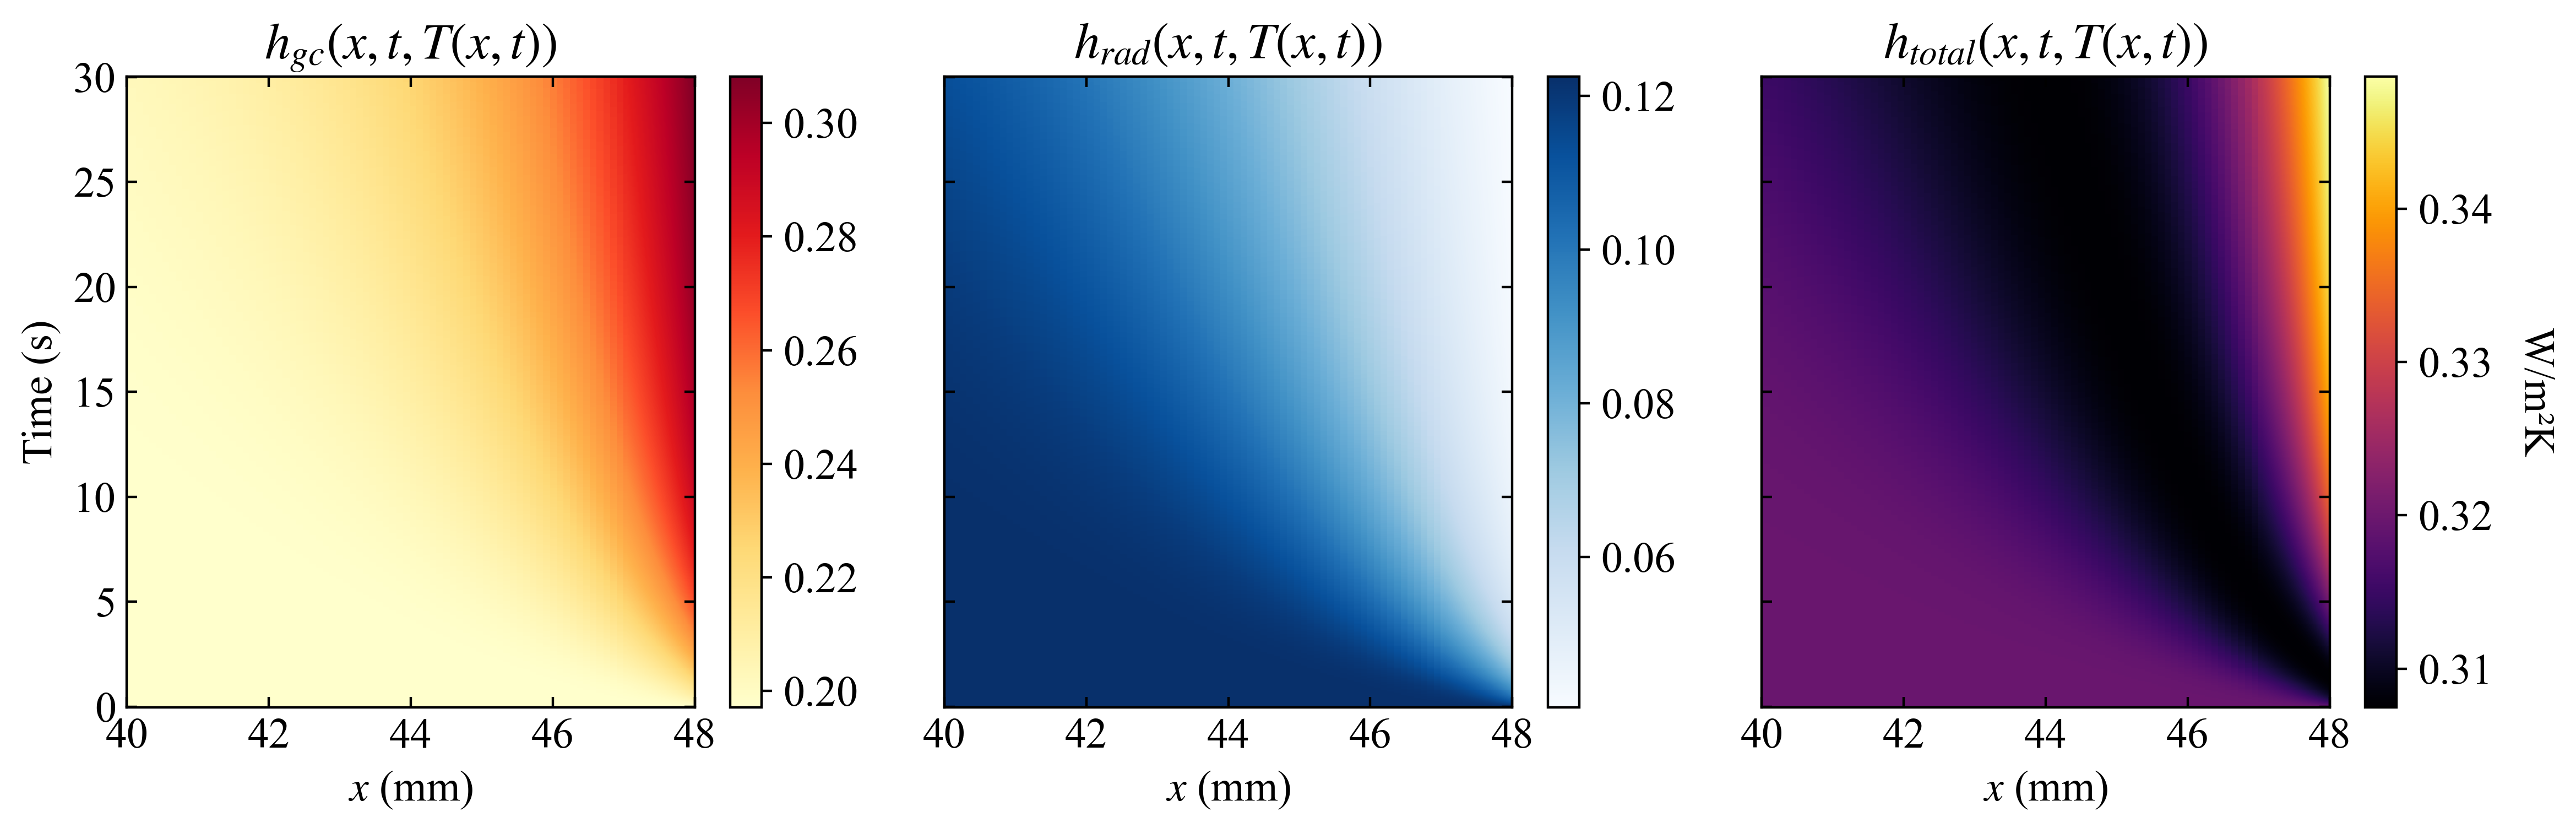

In [526]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_individual_heatmaps_with_cbars(x_vals, t_vals, h_gc_array, h_rad_array, h_total_array):
    x_mm = x_vals * 1000
    T_grid, X_grid = np.meshgrid(t_vals, x_mm)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    cmap_gc = cm.YlOrRd
    cmap_rad = cm.Blues
    cmap_total = cm.inferno

    # === vmin/vmax 따로 설정 ===
    vmin_gc, vmax_gc = h_gc_array.min(), h_gc_array.max()
    vmin_rad, vmax_rad = h_rad_array.min(), h_rad_array.max()
    vmin_total, vmax_total = h_total_array.min(), h_total_array.max()

    # ===== Plot 1 =====
    im1 = axs[0].pcolormesh(X_grid, T_grid, h_gc_array, cmap=cmap_gc, vmin=vmin_gc, vmax=vmax_gc, shading='auto')
    axs[0].set_title(r"$h_{gc}(x,t,T(x,t))$")
    axs[0].set_xlabel("$x$ (mm)")
    axs[0].set_ylabel("Time (s)")
    axs[0].set_xlim(40, 48)
    axs[0].set_xticks(np.arange(40, 50, 2))
    axs[0].tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)
    cbar1 = fig.colorbar(im1, ax=axs[0])
    #cbar1.set_label("W/m²·K", rotation=270, labelpad=20)

    # ===== Plot 2 =====
    im2 = axs[1].pcolormesh(X_grid, T_grid, h_rad_array, cmap=cmap_rad, vmin=vmin_rad, vmax=vmax_rad, shading='auto')
    axs[1].set_title(r"$h_{rad}(x,t,T(x,t))$")
    axs[1].set_xlabel("$x$ (mm)")
    axs[1].set_xlim(40, 48)
    axs[1].set_xticks(np.arange(40, 50, 2))
    axs[1].tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)
    cbar2 = fig.colorbar(im2, ax=axs[1])
    #cbar2.set_label("W/m²·K", rotation=270, labelpad=20)

    # ===== Plot 3 =====
    im3 = axs[2].pcolormesh(X_grid, T_grid, h_total_array, cmap=cmap_total, vmin=vmin_total, vmax=vmax_total, shading='auto')
    axs[2].set_title(r"$h_{total}(x,t,T(x,t))$")
    axs[2].set_xlabel("$x$ (mm)")
    axs[2].set_xlim(40, 48)
    axs[2].set_xticks(np.arange(40, 50, 2))
    axs[2].tick_params(axis='both', which='major', direction='in', labelsize=14, top=True, right=True)
    cbar3 = fig.colorbar(im3, ax=axs[2])
    cbar3.set_label("W/m²K", rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()
plot_individual_heatmaps_with_cbars(x_vals, t_vals, h_gc_array, h_rad_array, h_total_array)


In [225]:
# x = L 고정
xL = model.L
t_vals = model.t_values.flatten()

# 텐서 생성: shape = (len(t_vals), 1)
x_tensor = tf.ones_like(tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)) * xL
t_tensor = tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)
xt_tensor = tf.concat([t_tensor, x_tensor], axis=1)

# 예측된 T(t, x=L)
T_pred = model.model(xt_tensor)

# ri, ro 계산
x_tensor_input = x_tensor  # (N, 1)
ri = model.r_i(x_tensor_input)
ro = model.r_o(x_tensor_input)

# k_air 계산
k_air = model.k_air_dynamic(x_tensor_input, T_pred)

# 각 열전달 계수 계산
h_gc = (k_air / (ri * tf.math.log1p(ro / ri))).numpy().flatten()
h_rad = (model.sigma * model.epsilon_2 * 
         (model.T_inf**2 + T_pred.numpy().flatten()**2) * 
         (model.T_inf + T_pred.numpy().flatten()))
h_total = h_gc + h_rad


In [226]:
# === 시간 축 정의 (예: 0초부터 30초까지 0.5초 간격)
t_vals = np.linspace(0, 30, 61)
x_L = model.L  # x = L 위치

h_gc_time = []
h_rad_time = []
h_total_time = []

for t in t_vals:
    x_tensor = tf.convert_to_tensor([[x_L]], dtype=tf.float32)
    t_tensor = tf.convert_to_tensor([[t]], dtype=tf.float32)
    xt = tf.concat([t_tensor, x_tensor], axis=1)

    T_pred = model.model(xt)
    k_air = model.k_air_dynamic(x_tensor, T_pred)
    
    ri = model.r_o(x_tensor)  # r_o가 바깥쪽 지름
    ro = model.r_i(x_tensor)  # r_i가 안쪽 지름
    h_gc = (k_air / (ri * tf.math.log1p(ro / ri))).numpy().flatten()[0]
    h_rad = (model.sigma * model.epsilon_2 * 
             ((model.T_inf)**2 + T_pred.numpy()[0][0]**2) * 
             (model.T_inf + T_pred.numpy()[0][0]))
    
    h_total = h_gc + h_rad

    h_gc_time.append(h_gc)
    h_rad_time.append(h_rad)
    h_total_time.append(h_total)

h_gc_time = np.array(h_gc_time)
h_rad_time = np.array(h_rad_time)
h_total_time = np.array(h_total_time)


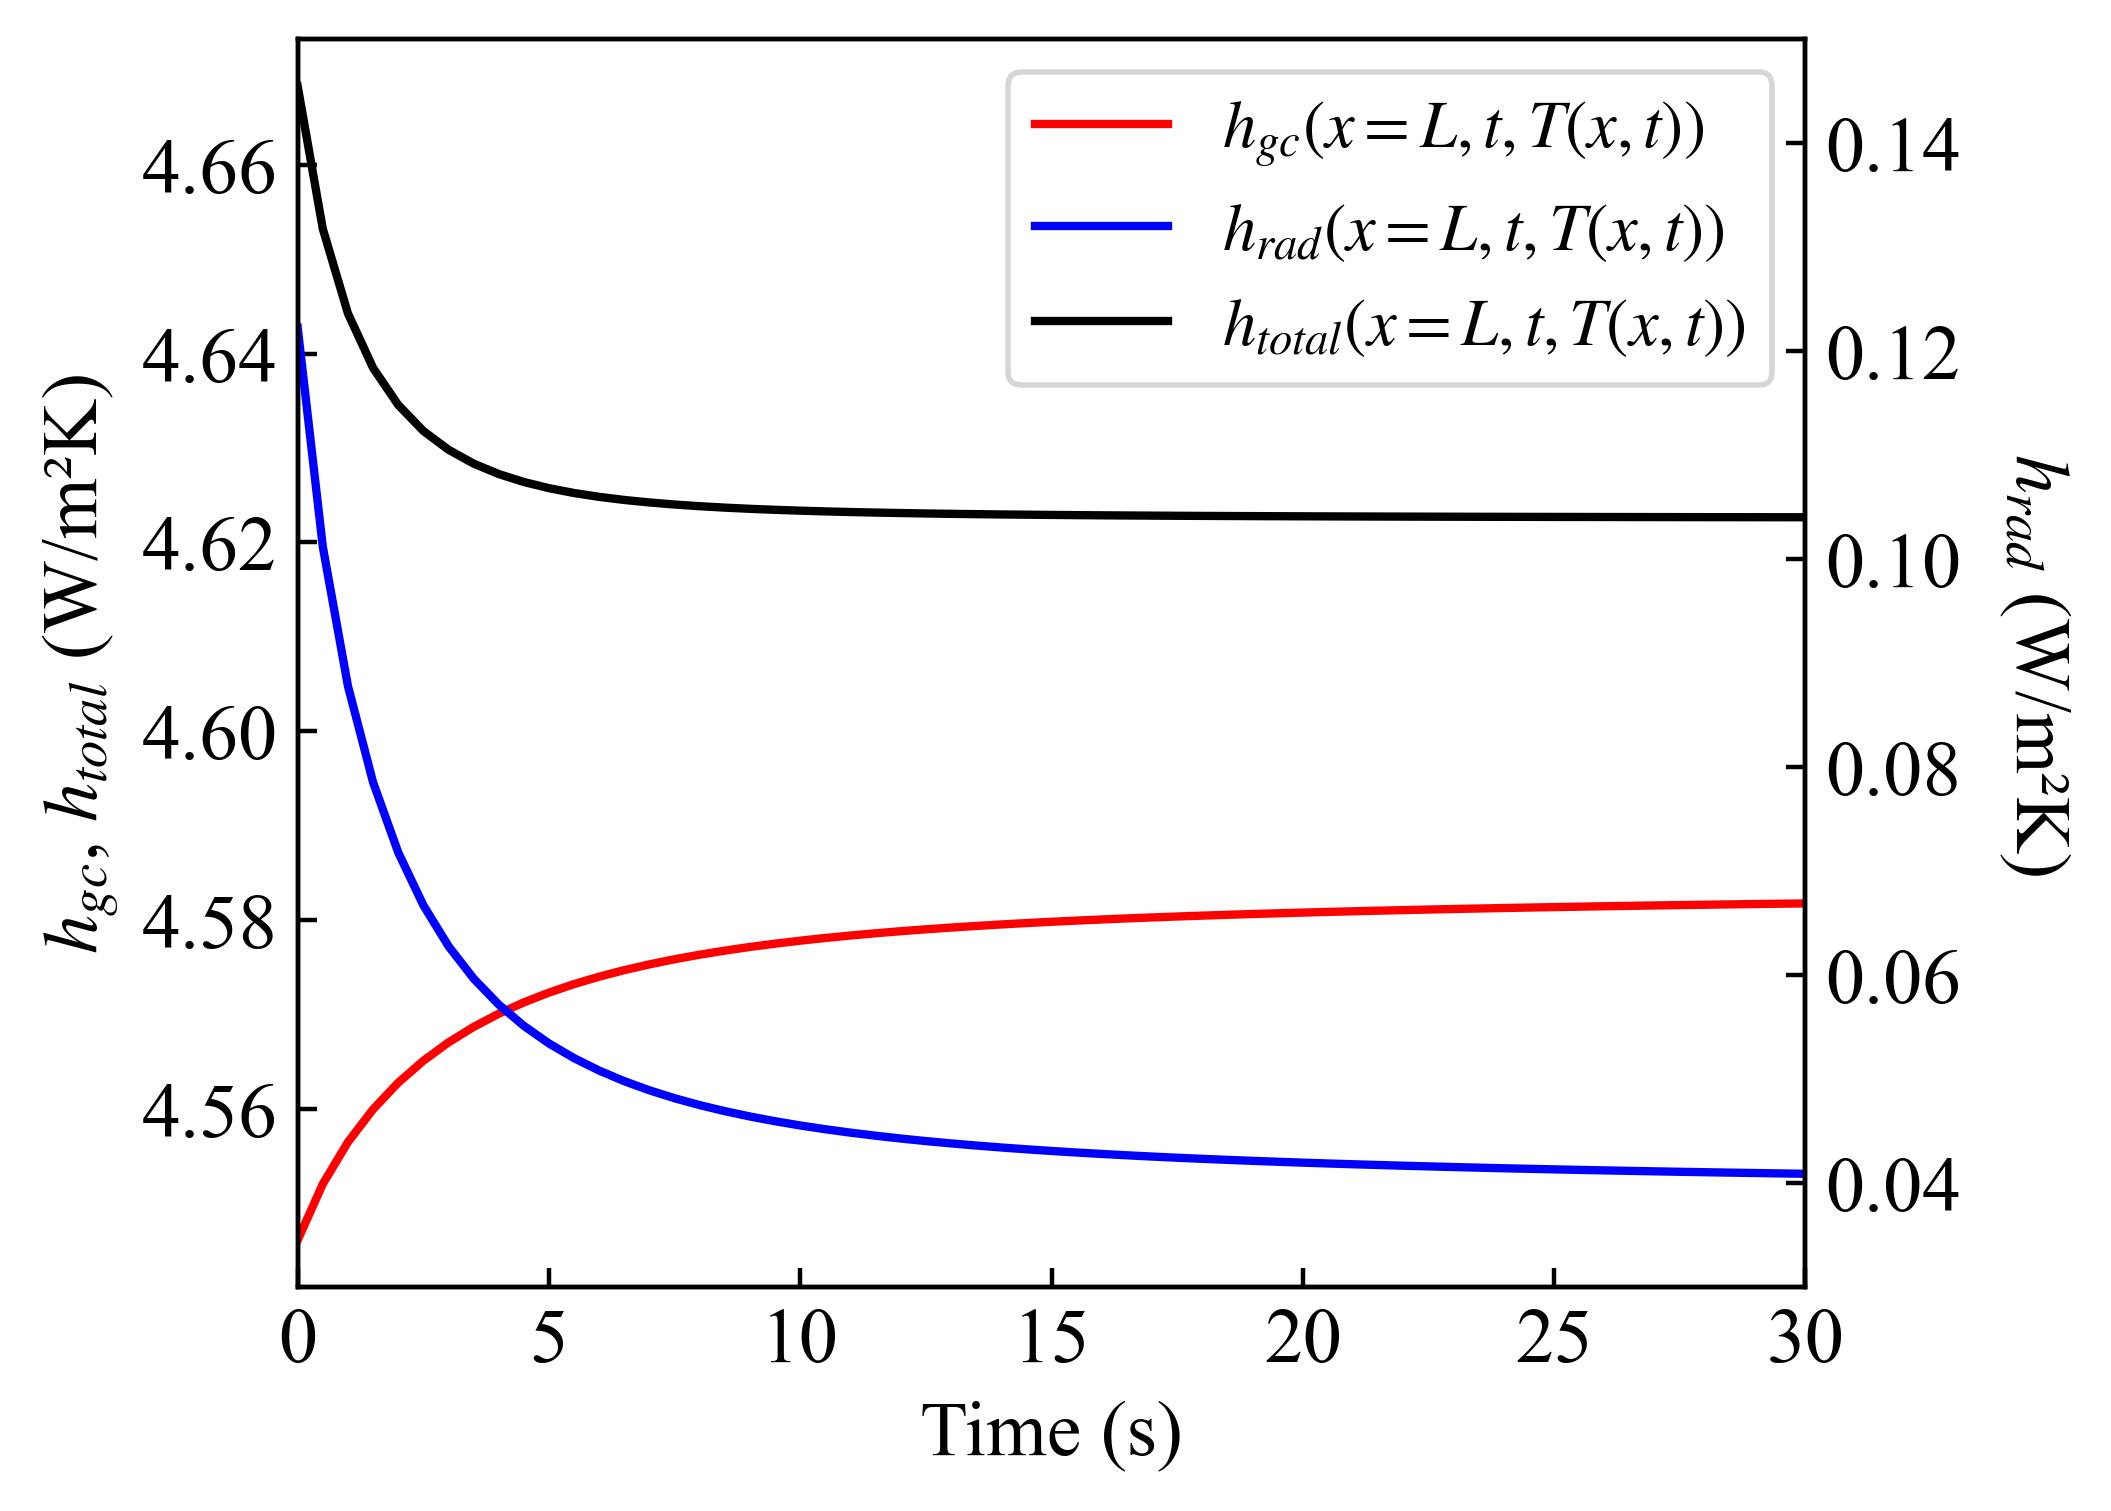

In [524]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# 예시 시간 축 (초 단위)
t = np.linspace(0, 30, len(h_gc_time))  # len(h_gc_time)는 예측된 값의 수

# 예측값: 시간대별로 x = L 위치에서 계산한 결과
h_gc = h_gc_time
h_rad = h_rad_time
h_total = h_total_time

# Figure 생성
fig, ax_left = plt.subplots(figsize=(5.5, 4))
ax_right = ax_left.twinx()

# ====== 좌측 y축: h_gc, h_total ======
ln1 = ax_left.plot(t, h_gc, color='red', linestyle='-', label=r"$h_{gc}(t)$")
ln2 = ax_left.plot(t, h_total, color='black', linestyle='-', label=r"$h_{total}(t)$")
ax_left.set_xlabel(r"Time (s)", fontsize=14)
ax_left.set_ylabel(r"$h_{gc}$, $h_{total}$ (W/m²K)", fontsize=14, color='black')
ax_left.tick_params(axis='y', labelcolor='black', labelsize=14, direction='in')
ax_left.set_xlim(0, 30)
ax_left.set_xticks(np.arange(0, 31, 5))
ax_left.set_ylim(min(h_gc.min(), h_total.min()) - 0.005,
                 max(h_gc.max(), h_total.max()) + 0.005)
ax_left.tick_params(axis='x', labelsize=14, direction='in')

# ====== 우측 y축: h_rad ======
ln3 = ax_right.plot(t, h_rad, color='blue', linestyle='-', label=r"$h_{rad}(t)$")
ax_right.set_ylabel(r"$h_{rad}$ (W/m²K)", fontsize=14, rotation=270, labelpad=20)
ax_right.tick_params(axis='y', labelsize=14, direction='in')
ax_right.set_ylim(0.03, 0.15)

# ====== 범례 순서 지정 ======
lns = [ln1[0], ln3[0], ln2[0]]
labels = [r"$h_{gc}(x=L,t,T(x,t))$", r"$h_{rad}(x=L,t,T(x,t))$", r"$h_{total}(x=L,t,T(x,t))$"]
ax_left.legend(lns, labels, loc='best', fontsize=12)

# ====== y축 소수점 2자리 포맷 ======
ax_left.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax_right.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()
plt.show()


In [228]:
x_vals = model.x_values.flatten()
t_vals = model.t_values.flatten()

# (시간, 위치) 모든 조합 생성
xt_vals = np.array([[t, x] for t in t_vals for x in x_vals], dtype=np.float32)
xt_tensor = tf.convert_to_tensor(xt_vals, dtype=tf.float32)

# 예측 실행
T_pred = model.model(xt_tensor).numpy().flatten()
T_matrix = T_pred.reshape(len(t_vals), len(x_vals))  # shape: (N_t, N_x)

# 저장
results_T_xt = T_matrix

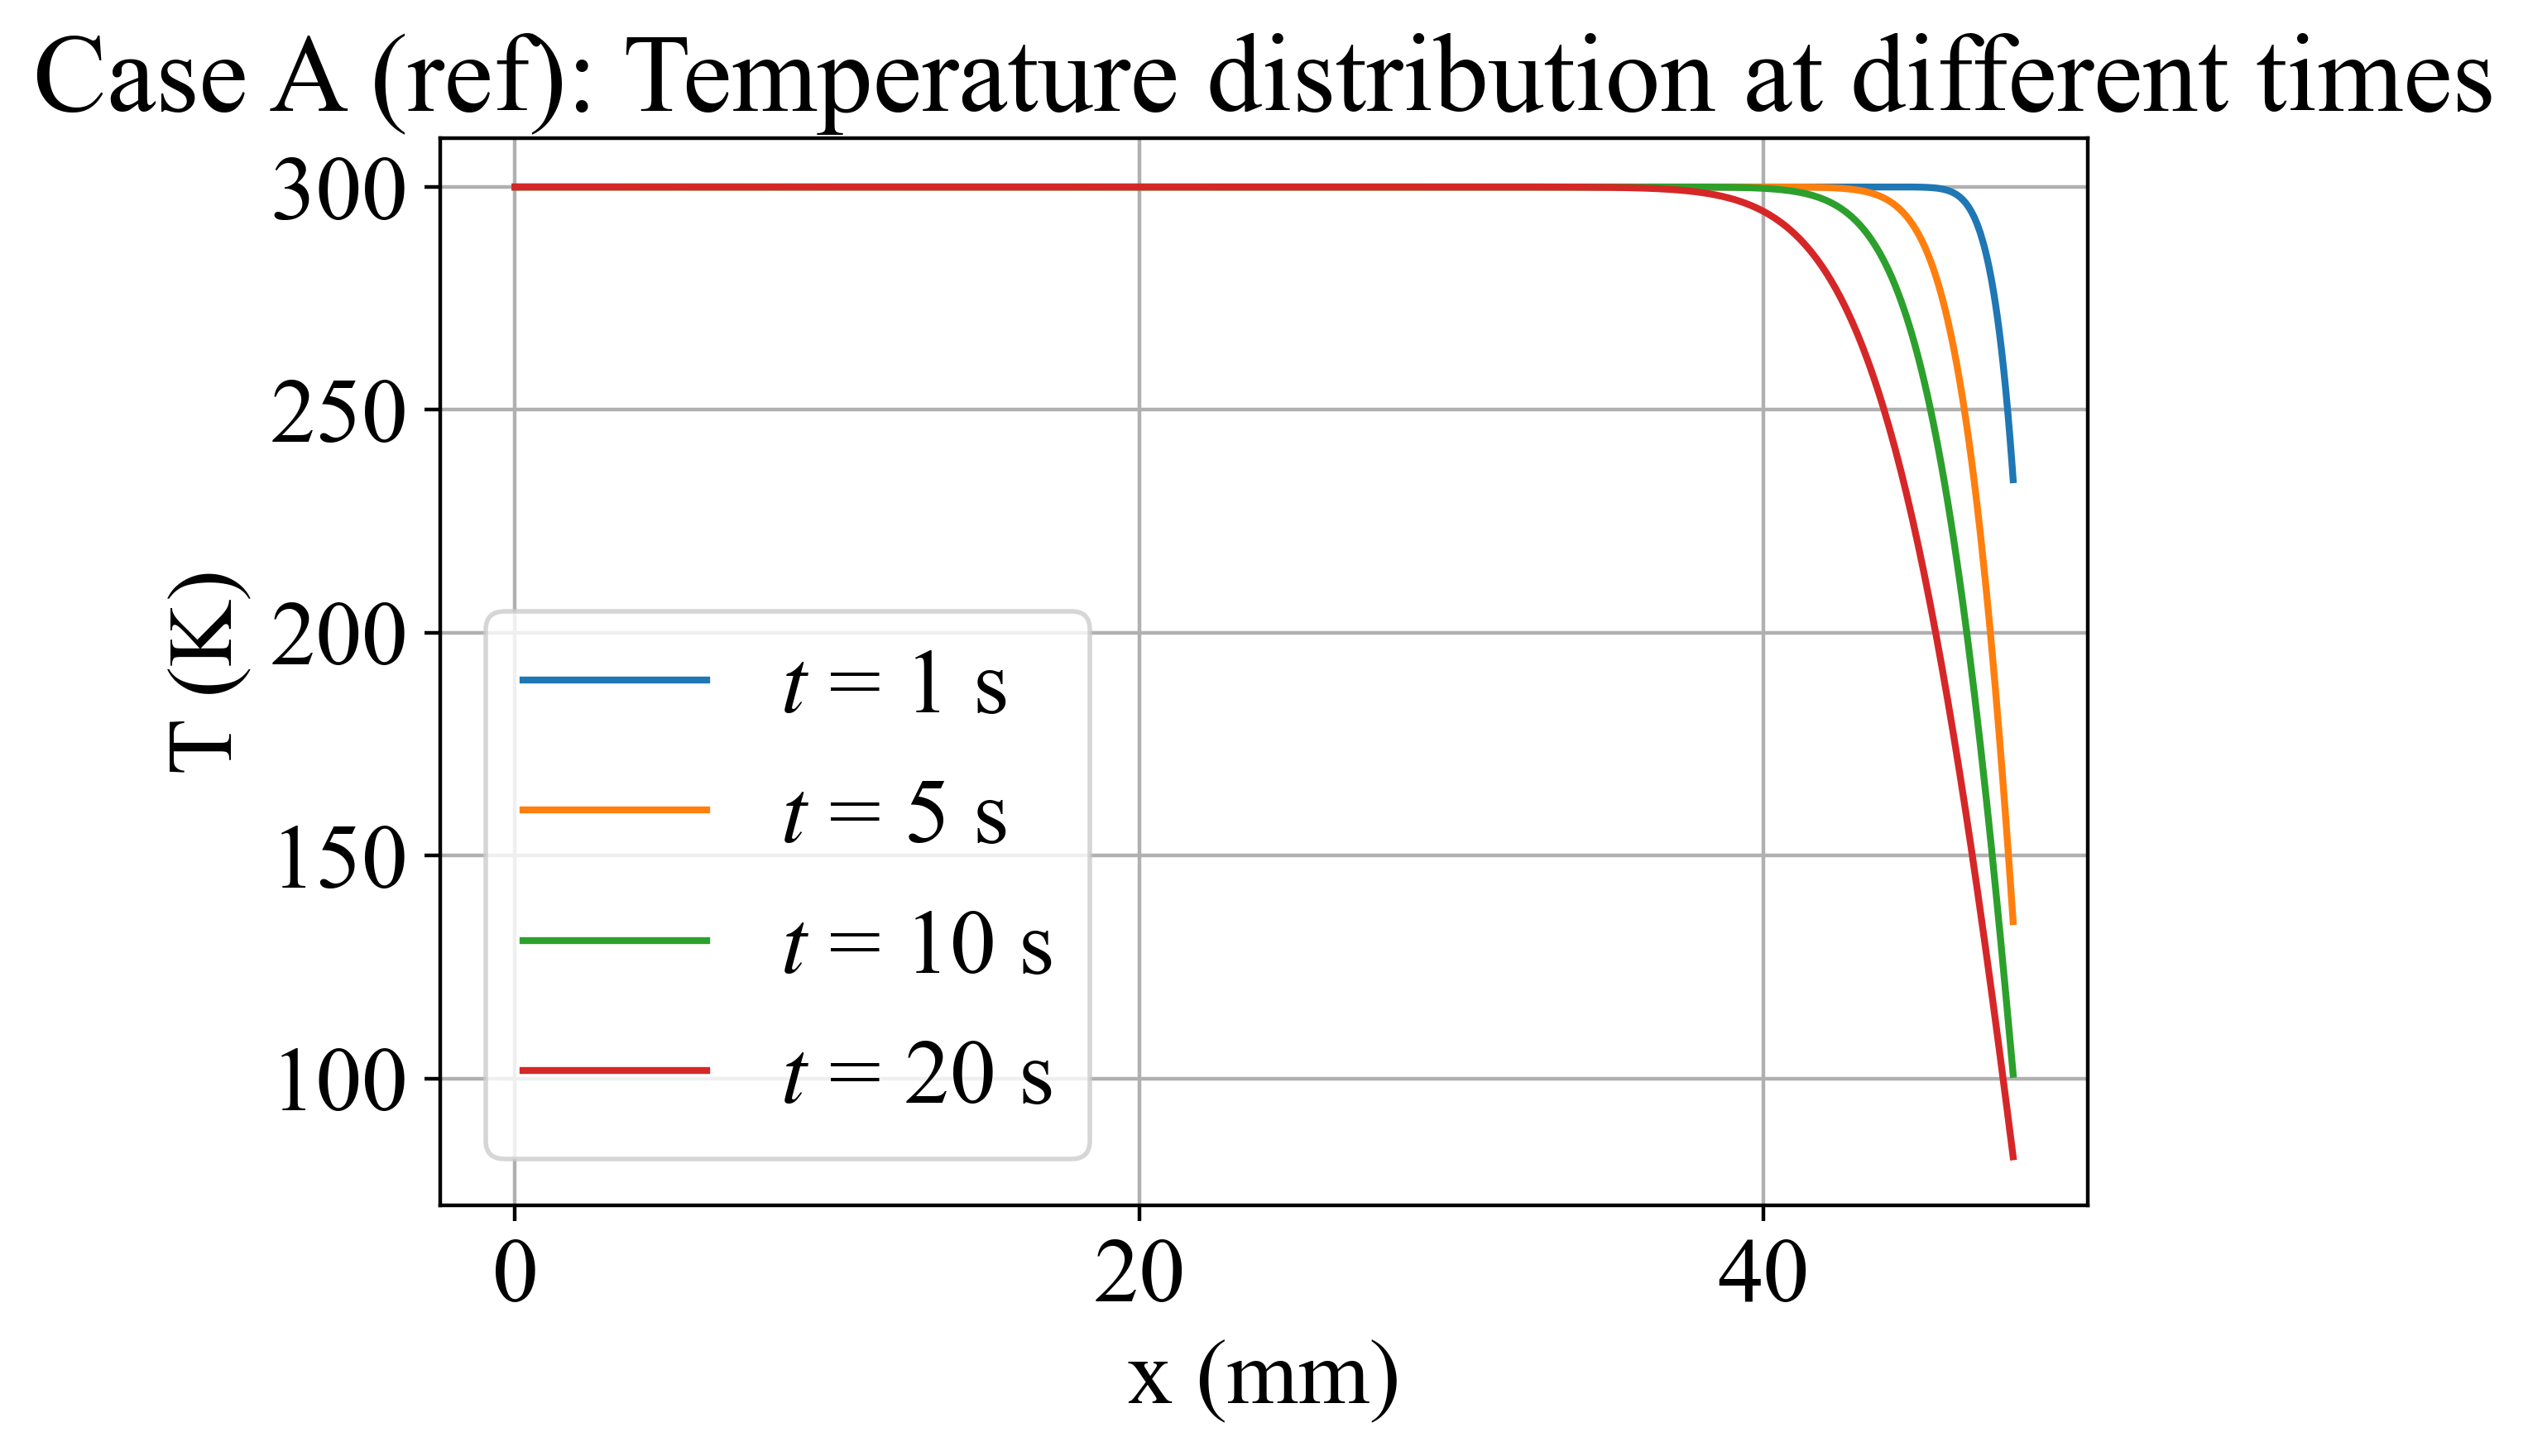

In [229]:
import pandas as pd
import os

# 저장 폴더 설정
output_dir = "./temperature_snapshots"
os.makedirs(output_dir, exist_ok=True)

time_snapshots = [1, 5, 10, 20]

for t in time_snapshots:
    idx = np.argmin(np.abs(t_vals - t))
    temperature_at_t = T_matrix[idx]
    
    # Plot
    plt.plot(x_vals * 1000, temperature_at_t, label=f"$t$ = {t} s")

    # Save to CSV
    df = pd.DataFrame({
        "x (mm)": x_vals * 1000,
        "T (K)": temperature_at_t
    })
    filename = f"T_x_t{t}.csv"
    df.to_csv(os.path.join(output_dir, filename), index=False)

plt.xlabel("x (mm)")
plt.ylabel("T (K)")
plt.title(f"{label}: Temperature distribution at different times")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/vq/tqxj_cr17_vgpvmk2hzmj_tw0000gn/T/ipykernel_8311/1091516766.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(m, shrink=0.5, aspect=10, label='Temperature (K)')


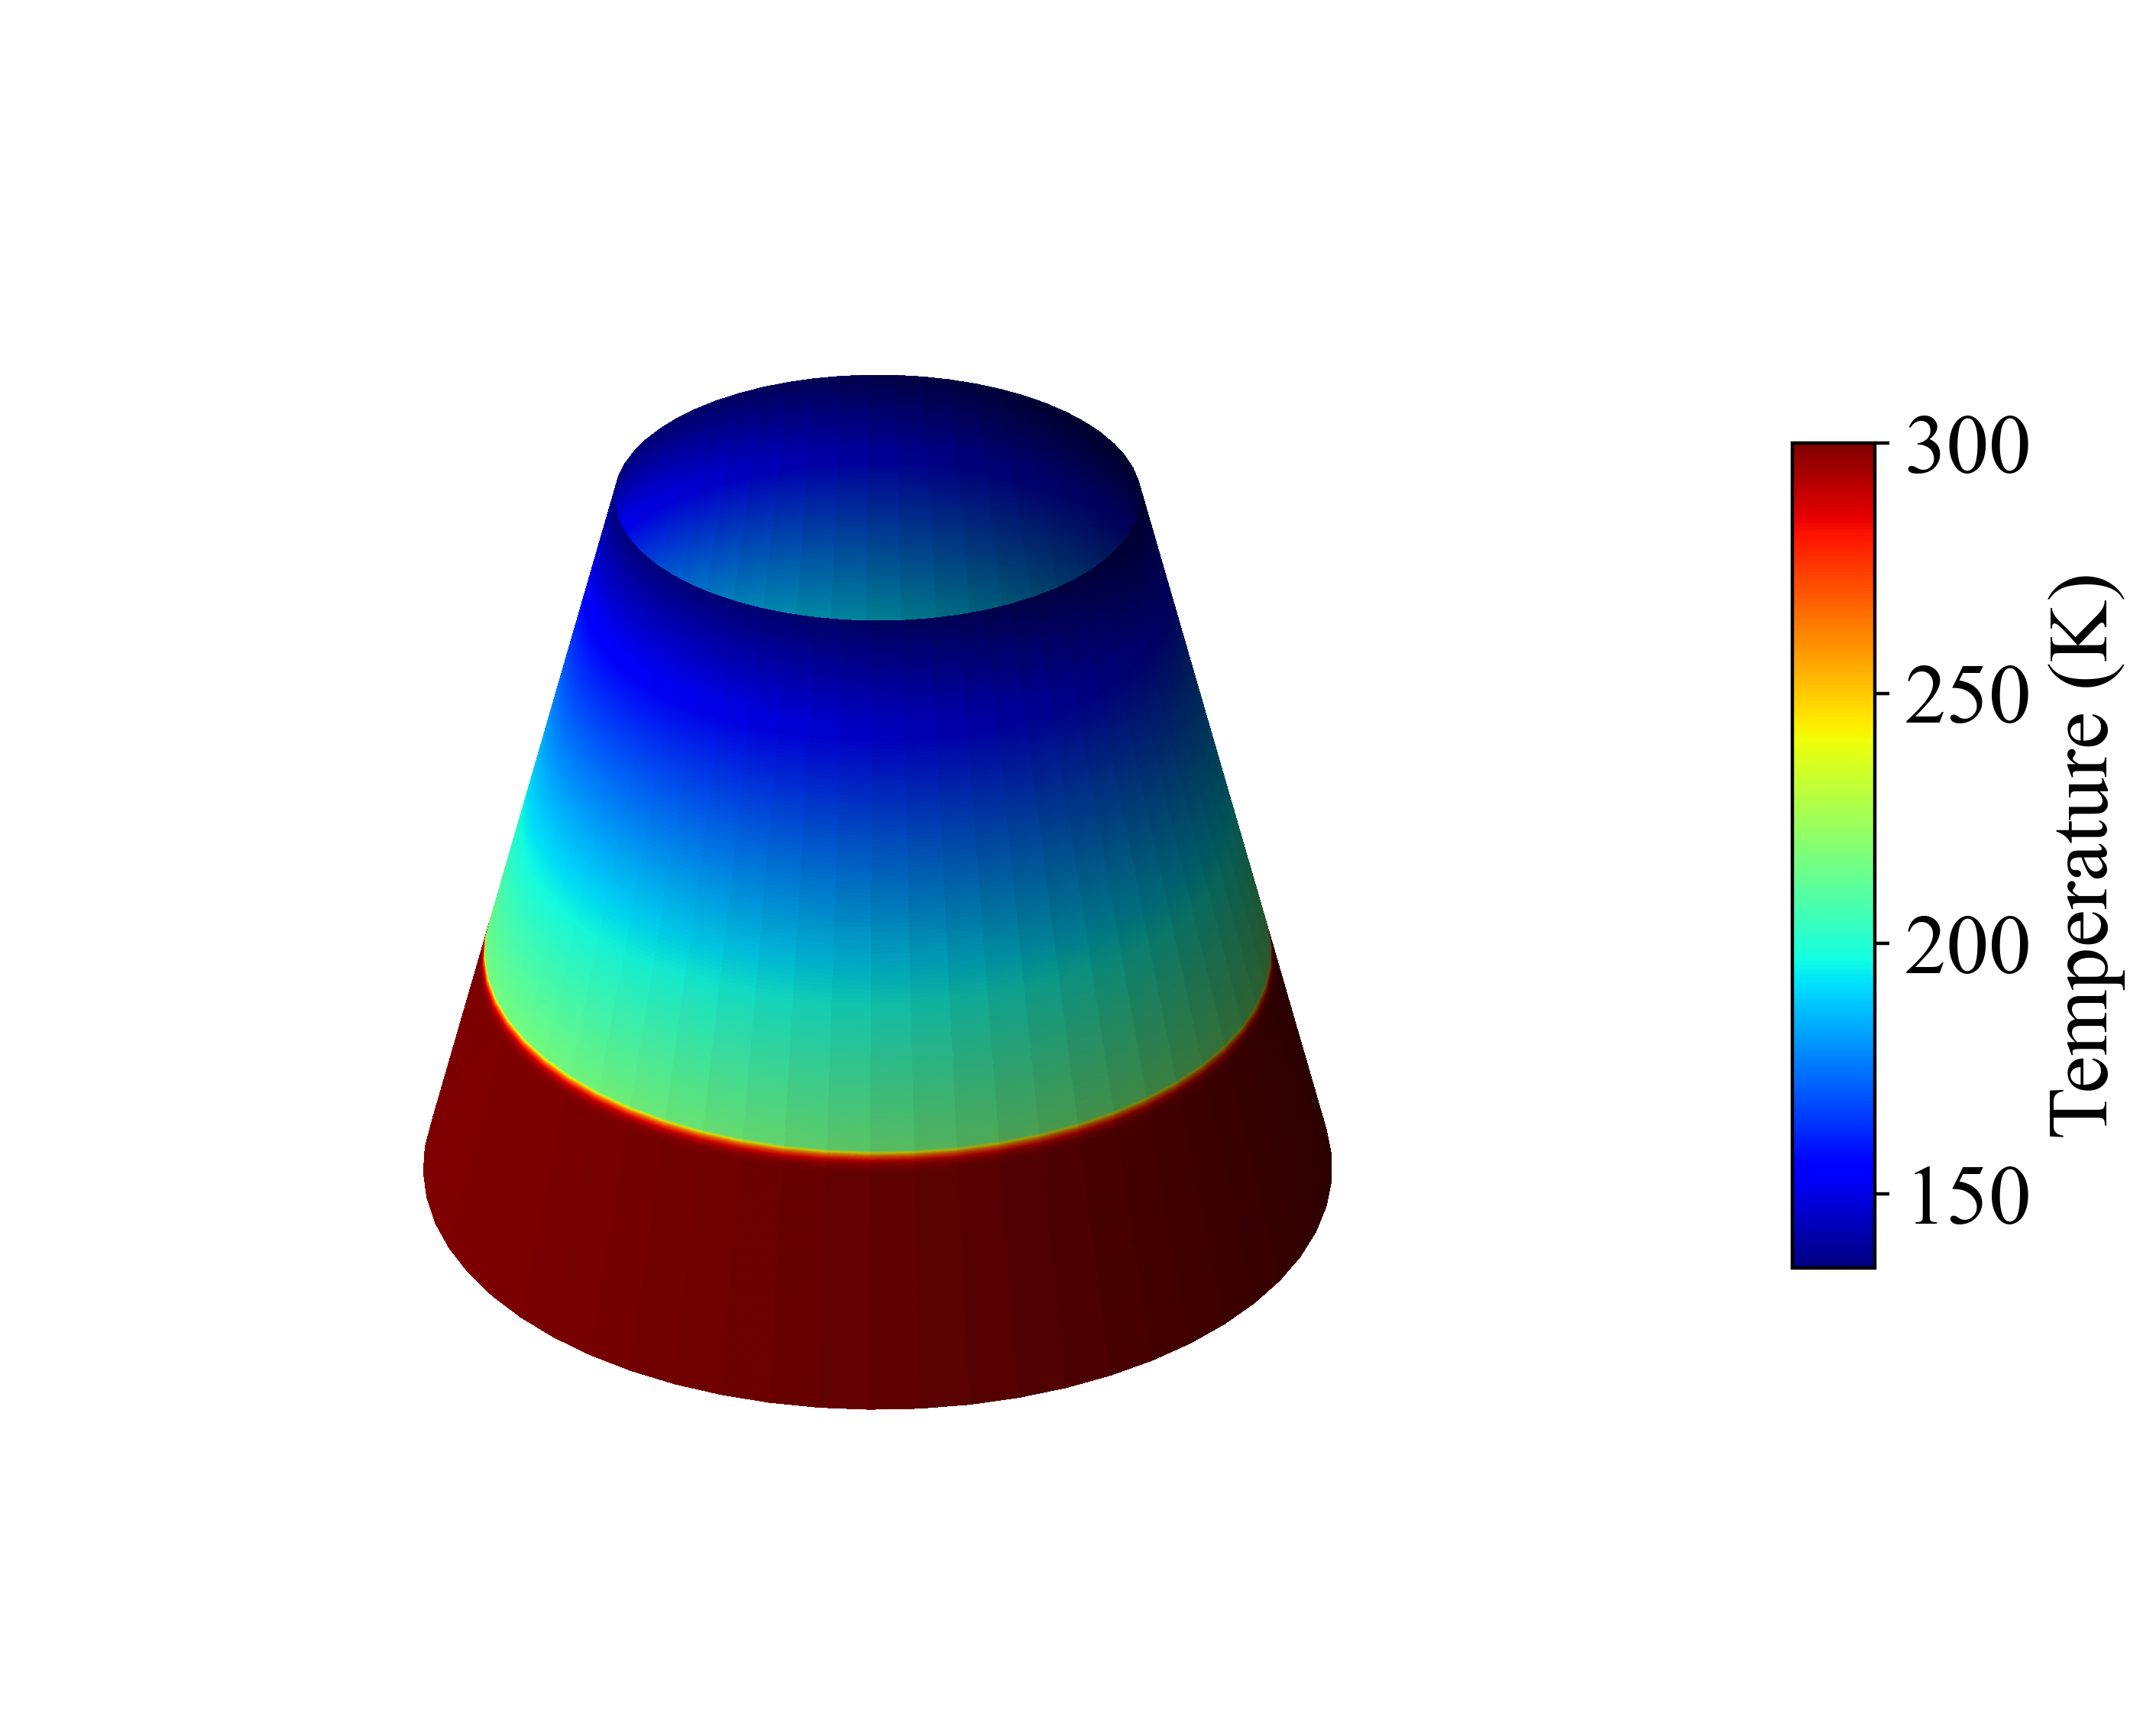

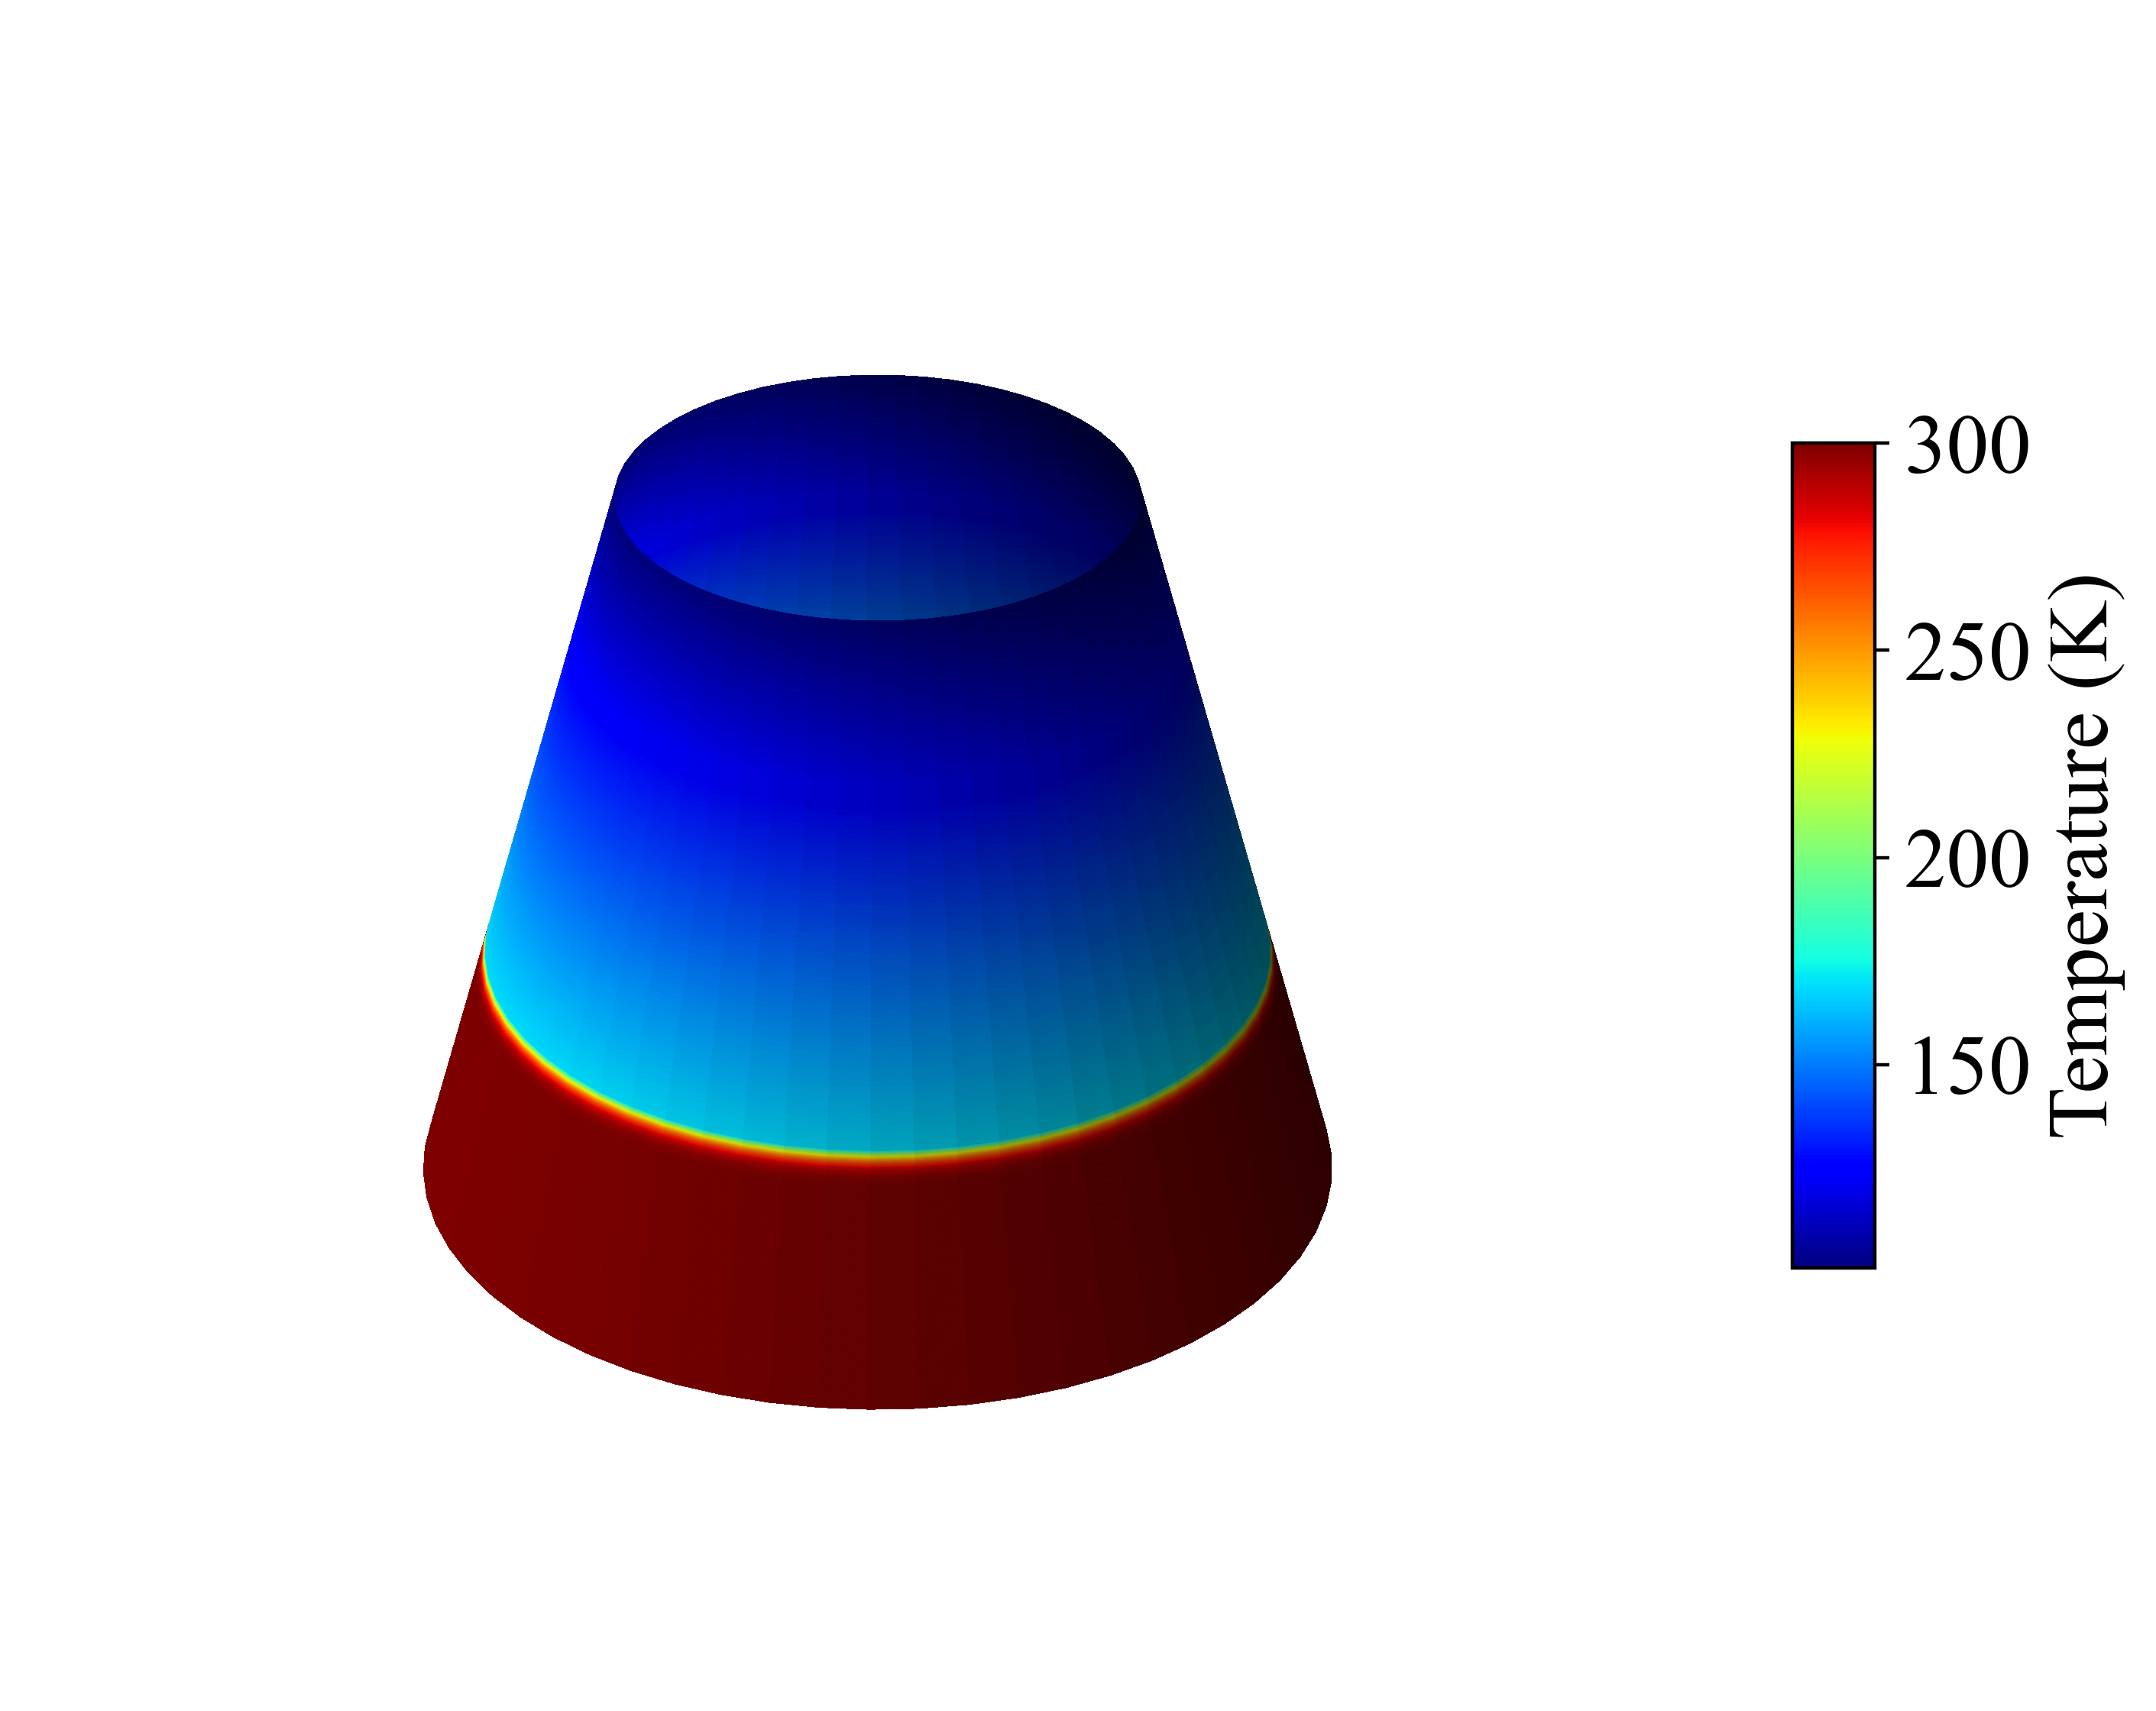

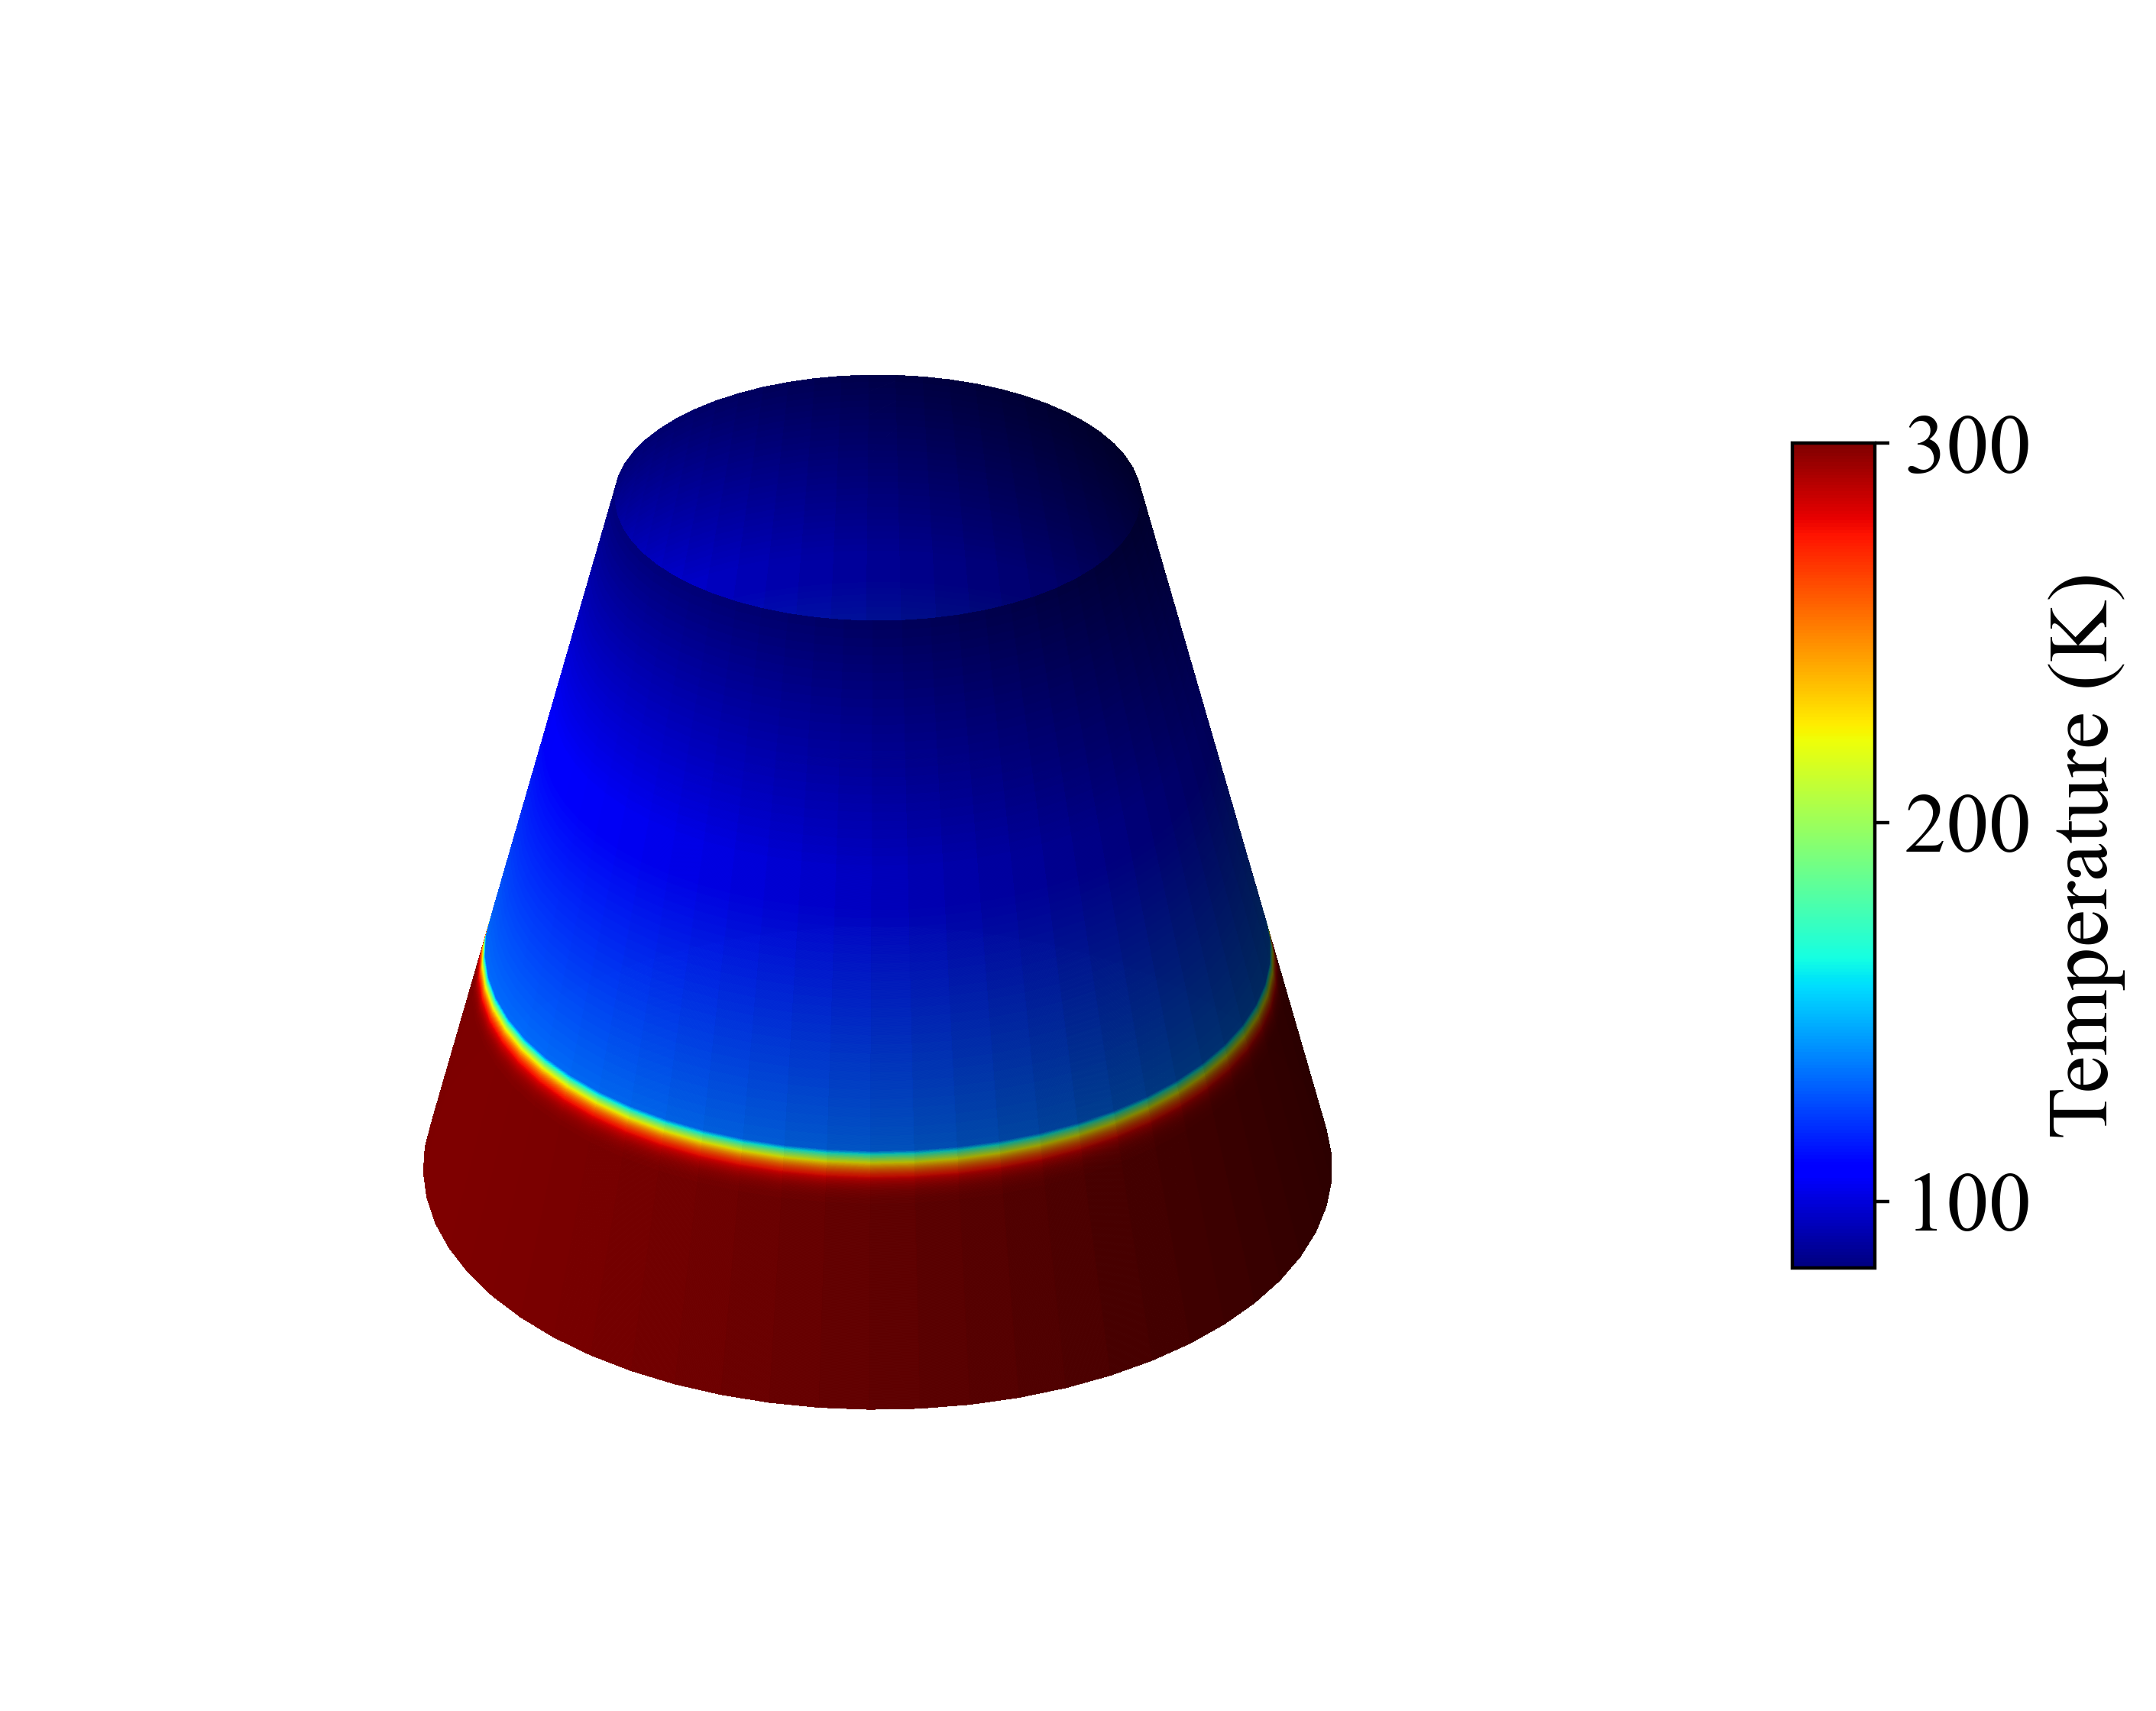

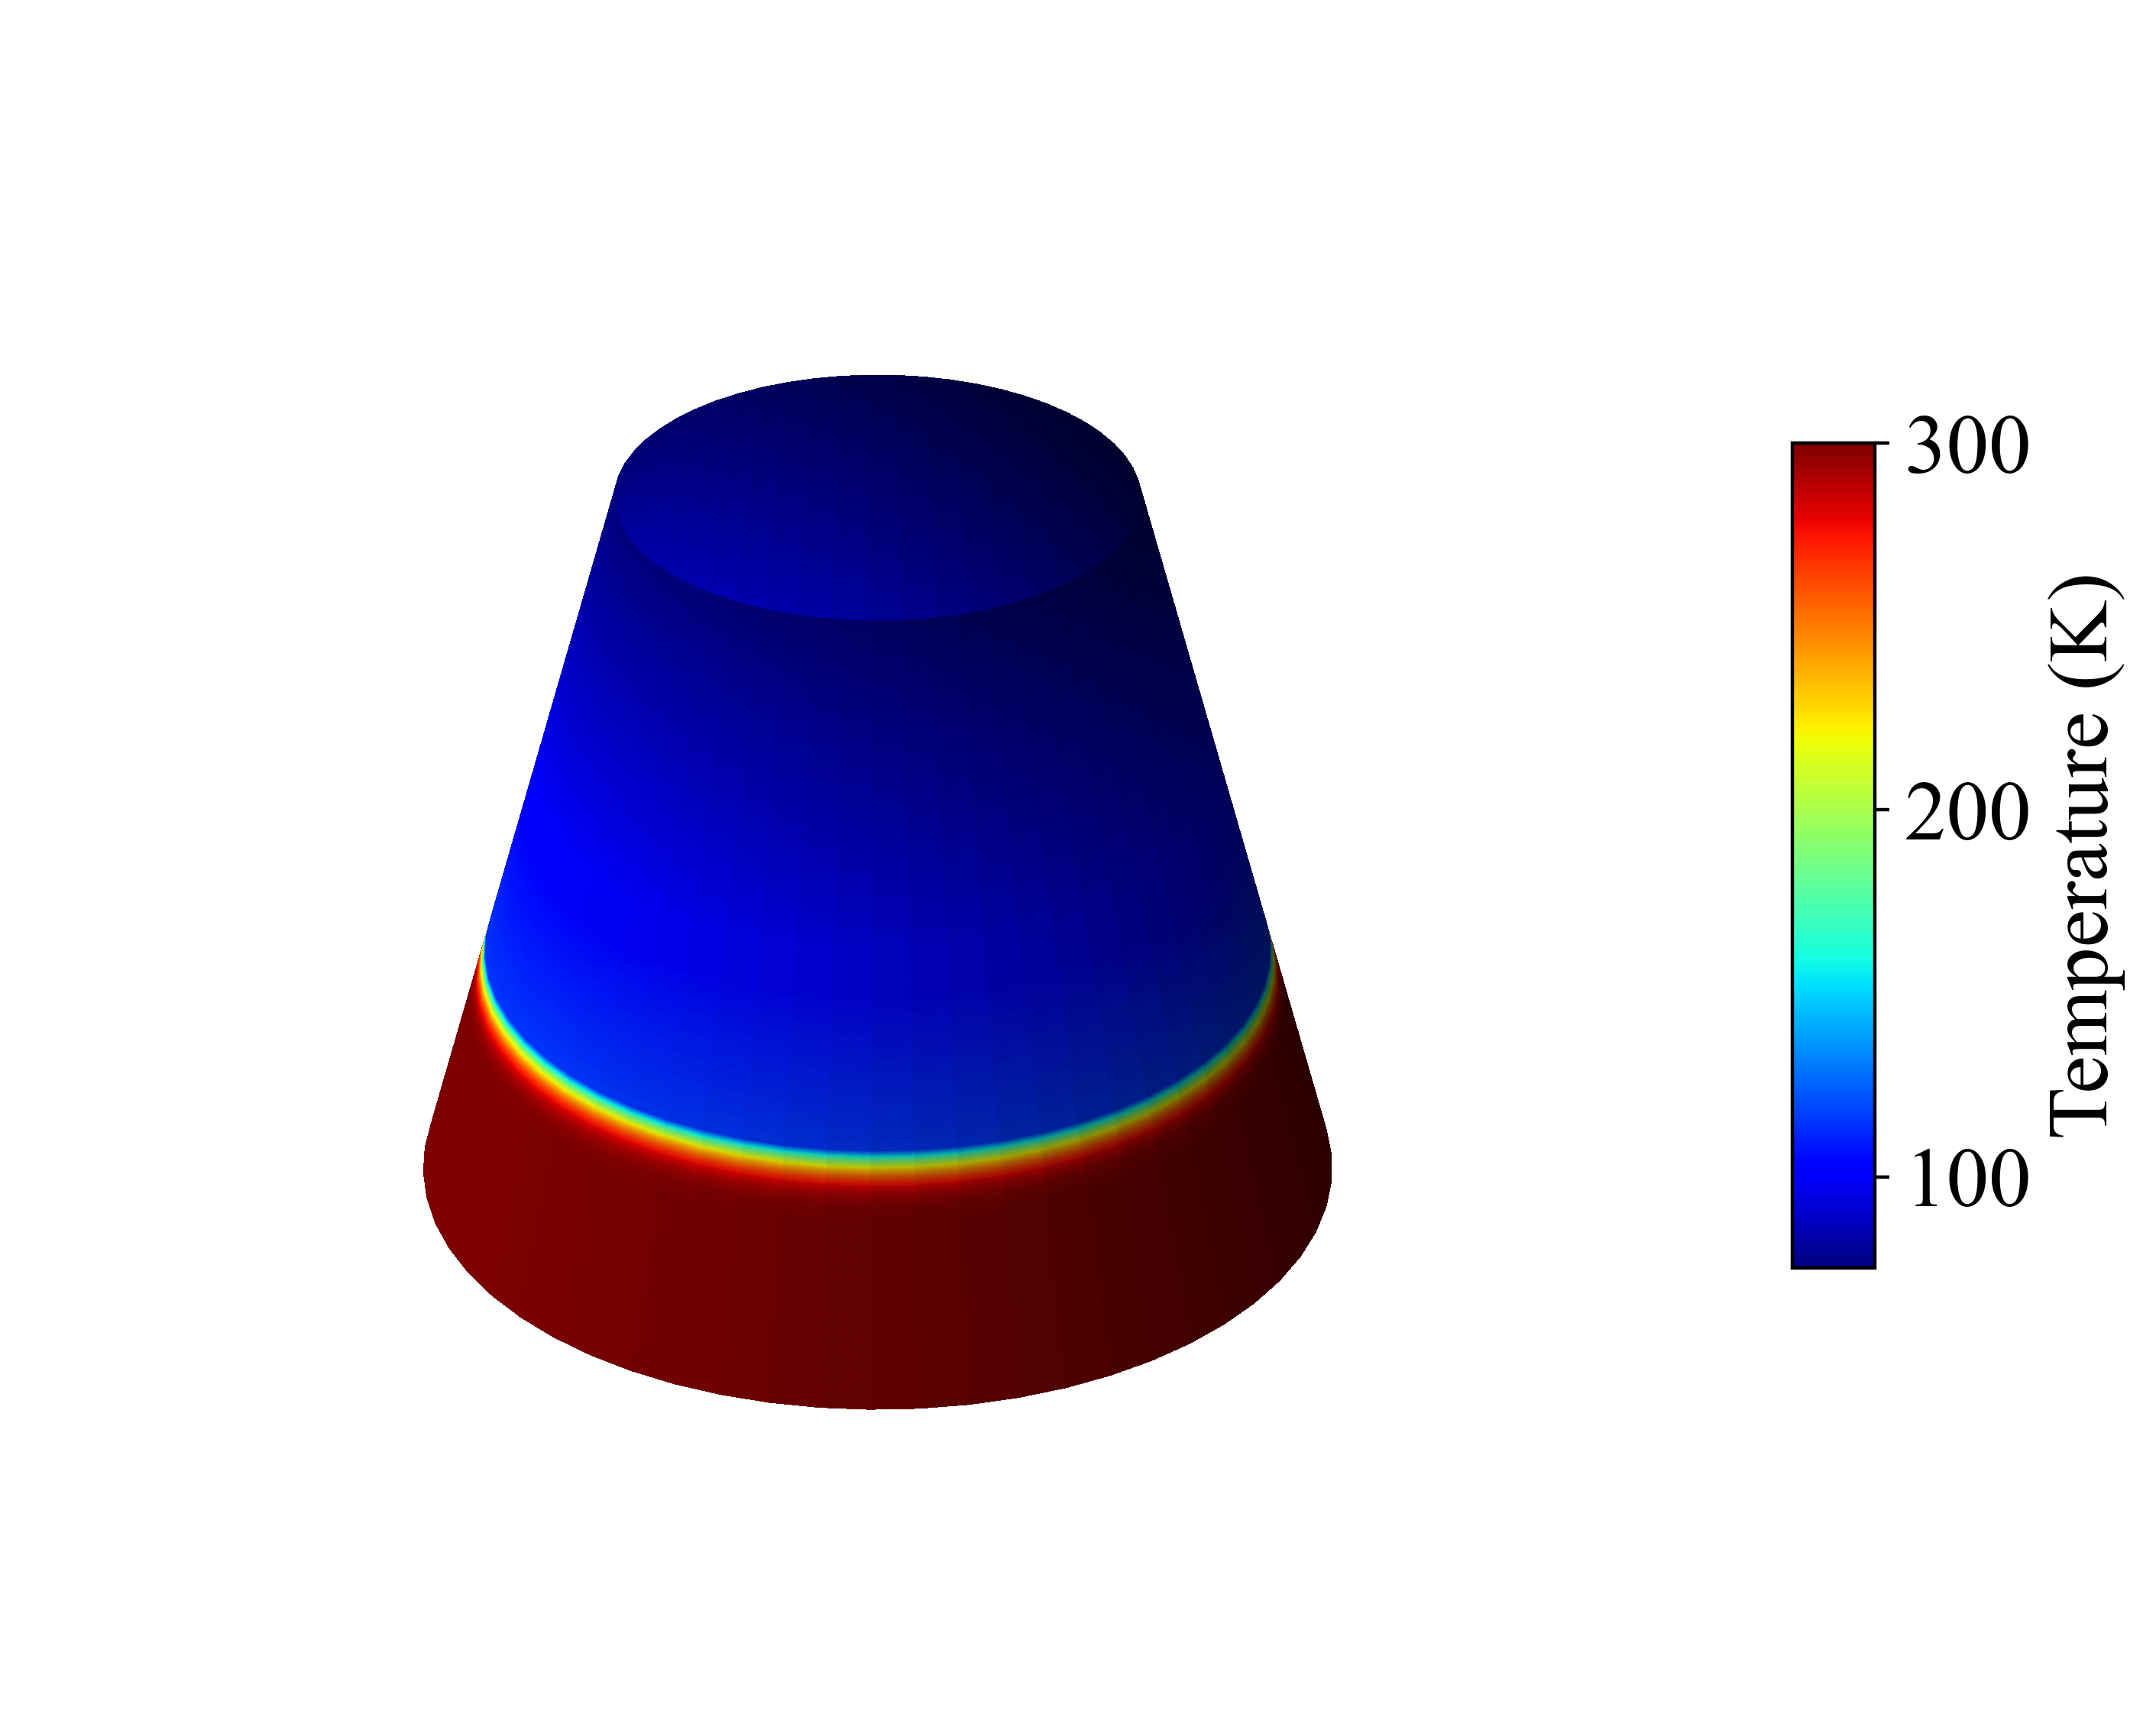

In [230]:
# 데이터 재로드 후 시각화 수행 (코드 실행 환경 초기화로 인한 재시도)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 파일 경로
files = {
    5: "./temperature_snapshots/T_x_t5.csv",
    10: "./temperature_snapshots/T_x_t10.csv",
    20: "./temperature_snapshots/T_x_t20.csv",
    30: "./temperature_snapshots/T_x_t30.csv"
}

# 테이퍼드 원통 파라미터
R_bottom = 9
R_top = 5
height = 48
theta_res = 60

# 온도 시각화 함수
def plot_temp_surface(T_data, t_sec):
    z_res = len(T_data)
    z = np.linspace(0, height, z_res)
    theta = np.linspace(0, 2 * np.pi, theta_res)
    theta, z = np.meshgrid(theta, z)
    r = R_bottom + (R_top - R_bottom) * (z / height)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    T_repeat = np.tile(T_data.reshape(-1, 1), (1, theta_res))

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        x, y, z,
        facecolors=plt.cm.jet((T_repeat - T_repeat.min()) / (T_repeat.max() - T_repeat.min())),
        rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=0.9
    )

    # ✅ 모든 축 숨기기
    ax.set_axis_off()

    # Colorbar
    m = plt.cm.ScalarMappable(cmap=plt.cm.jet)
    m.set_array(T_repeat)
    fig.colorbar(m, shrink=0.5, aspect=10, label='Temperature (K)')

    plt.tight_layout()
    plt.show()


# 수정된 데이터 로딩 (헤더 무시)
def load_temperature_data(filepath):
    return np.genfromtxt(filepath, delimiter=",", skip_header=1)[:, 1]  # 두 번째 열 (온도)만 추출

# 파일 별 시각화 실행
for t_sec, file_path in files.items():
    T_data = load_temperature_data(file_path)
    plot_temp_surface(T_data, t_sec)

